In [1]:
import numpy as np

In [2]:
a = np.array([1, 2, 3, 4, 5])

In [3]:
a.argsort(axis=0)[]

array([0, 1, 2, 3, 4], dtype=int64)

df(t) : the number of docs that contain t

tf(t,d) : the number of times that term t occurs in doc d

idf(t) : log(N/df(t), 10)

df(t) : len(index[t].posting_list)

tf(t,d) : index[t][d].get(body, 0) + 2 * index[t][d].get(title, 0)

idf(t) : log(N/df(t), 10)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys

sys.path.append("/content/drive/My Drive/phase2")

In [0]:
import numpy as np

import json
import multiprocessing
import nltk
import pickle
import math
import time
import os
import re
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numba as nb
import numexpr as ne

from sklearn import svm
from numba import njit
from utils import *
# from KNN import knn
from functools import partial
from nltk.stem import WordNetLemmatizer
from collections import Counter, OrderedDict
from tqdm import tqdm
# from distance_criteria import euclidean_distance
from numpy.linalg import norm
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/content/drive/My Drive/phase2/utils.py:107: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  return np.dot(train_matrix, val_matrix)


In [0]:
base_dir = '/content/drive/My Drive/phase2/'

In [0]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
class Distance_Criteria:
    cosine_similarity = 'cosine_similarity'
    euclidean_distance = 'euclidean_distance'

class NltkMethod:
    stemming = 'stemming'
    lemmatization = 'lemmatization'
    stop_word_removal = 'stop_word_removal'
    simple = 'simple'

In [0]:
distance_criteria = Distance_Criteria.cosine_similarity
nltk_method = NltkMethod.simple

In [0]:
# import zipfile


# with zipfile.ZipFile('{}similarity_scores.zip'.format(base_dir), 'r') as zip_ref:
#     zip_ref.extractall('{}'.format(base_dir))


# load data

In [0]:
training_data_path = '{}data/train.json'.format(base_dir)
test_data_path = '{}data/validation.json'.format(base_dir)

with open(training_data_path) as training_data_file:
    training_data = sorted(json.loads(training_data_file.read()), key = lambda x: x['title'])

with open(test_data_path) as test_data_file:
    test_data = sorted(json.loads(test_data_file.read()), key = lambda x: x['title'])

In [0]:
categories = [1, 2, 3, 4]
N = len(training_data)
K = [1, 3, 5]
# ps = []
# rs = []
# acs = []
# f1s = []
# names = []

# Extract Terms

## train

In [0]:
if os.path.isfile('{}{}_index.pickle'.format(base_dir, nltk_method)):
    train_index = load_pickle('{}{}_index.pickle'.format(base_dir, nltk_method))
else:
    train_index = {}
    for doc_id, doc in tqdm(enumerate(training_data), total=len(training_data)):
        extract_terms(doc, doc_id, train_index, nltk_method_name=nltk_method)
    save_pickle('{}{}_index.pickle'.format(base_dir, nltk_method), train_index)

file loaded


## test

In [0]:
test_index = {}

for test_doc_id, test_doc in enumerate(test_data):
    extract_terms(test_doc, test_doc_id, test_index, nltk_method)

# Train Doc Norms

In [0]:
# train_norms = np.zeros((len(training_data)), dtype=np.float32)
# for term, data in tqdm(train_index.items()):
#     df = len(data.posting_list)
#     idf = math.log10(N / df)
#     for doc_id, doc_data in data.posting_list.items():
#         train_norms[doc_id] += ((doc_data.get('body', 0) + 2 * doc_data.get('body', 0)) * idf) ** 2

# Build Doc Vectors

## train

In [0]:
idx = 0
train_matrix = np.zeros((len(training_data), len(train_index)), dtype=np.float32)
mappings = {}
reverse_mappings = {}
for term, term_data in train_index.items():
    mappings[term] = idx
    reverse_mappings[idx] = term
    df = len(term_data.posting_list)
    idf = math.log10(N / df)
    for doc, doc_data in term_data.posting_list.items():
        train_matrix[doc][idx] = (doc_data.get('body', 0) + 2 * doc_data.get('title', 0)) * idf
    idx += 1

## test

In [0]:
test_matrix = np.zeros((len(test_data), len(train_index)), dtype=np.float32)
for term, term_data in test_index.items():
    df = len(term_data.posting_list)
    idf = math.log10(N / df)
    term_in_train = mappings.get(term, False)
    if term_in_train:
        for doc, doc_data in term_data.posting_list.items():
            test_matrix[doc][term_in_train] = (doc_data.get('body', 0) + 2 * doc_data.get('title', 0)) * idf


# Build Labels Vector

## train

In [0]:
train_labels = np.zeros((len(training_data)), dtype=np.uint8)
for doc_id, doc in tqdm(enumerate(training_data), total=len(training_data)):
    train_labels[doc_id] = doc['category']

100%|██████████| 24000/24000 [00:00<00:00, 965521.07it/s]


## test

In [0]:
test_labels = np.zeros((len(test_data)), dtype=np.uint8)
for doc_id, doc in tqdm(enumerate(test_data), total=len(test_data)):
    test_labels[doc_id] = doc['category']

100%|██████████| 3000/3000 [00:00<00:00, 918393.69it/s]


# KNN

In [0]:
def get_doc_category(doc_id):
    return training_data[doc_id]['category']

In [0]:
config = {
    'cosine_similarity':{
        'func' : partial(knn_cosine_similarity, train_matrix=train_matrix, test_matrix=test_matrix)
    },
    'euclidean_distance':{
        'func' : partial(knn_euclidean_distance, train_index=train_index, test_index=test_index, training_data_number=len(training_data), test_data_number=len(test_data), N=N)
    }
}

In [0]:
result_doc_id = config[distance_criteria]['func']()

# Evaluate Results

### Confusion Matrix

In [0]:
c_matrix = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
], dtype=np.uint64)
confusion_matrix = {}

for k in K:
    confusion_matrix[k] = np.copy(c_matrix)

In [0]:
for idx, result in tqdm(enumerate(result_doc_id.T), total=len(result_doc_id)):
    for k in K:
        predicted_category = Counter([training_data[doc_id]['category'] for doc_id in result[:k]]).most_common(1)[0][0]
        confusion_matrix[k][predicted_category-1][test_data[idx]['category']-1] += 1

3000it [00:00, 23250.02it/s]


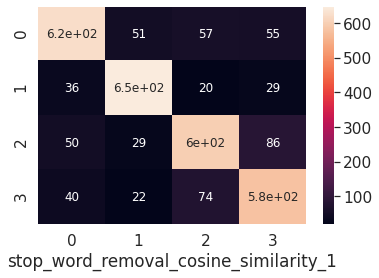

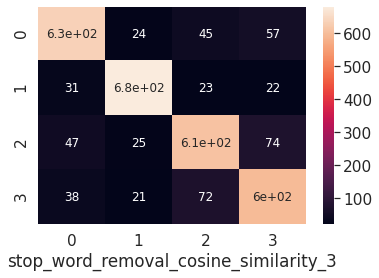

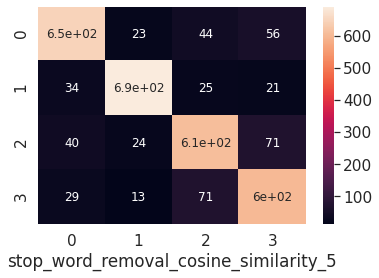

In [0]:
for k in K:
  df_cm = pd.DataFrame(confusion_matrix[k], range(4), range(4))
  # plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
  plt.xlabel("{}_{}_{}".format(nltk_method, distance_criteria, k))
  plt.show()

### Precision

cosine_similarity
knn mean precision with k=1 -> 0.817752462436256
knn mean precision with k=3 -> 0.8401536694299852
knn mean precision with k=5 -> 0.8492784061576008


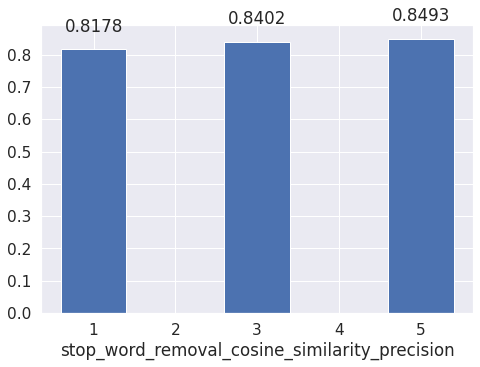

In [0]:
mean_precisions = []
precisions = {}
print(distance_criteria)
for k in K:
    aux = []
    for c in categories:
        precision = confusion_matrix[k][c-1][c-1] / np.sum(confusion_matrix[k][c-1])
        aux.append(precision)
    precisions[k] = aux
    mean_precisions.append(sum(aux) / 4)
    print('knn mean precision with k={} ->'.format(k), sum(aux) / 4)
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
rects = ax.bar(K, mean_precisions)
ax.set_xlabel('{}_{}_precision'.format(nltk_method, distance_criteria))
autolabel(rects, ax)

### Recall

cosine_similarity
knn mean recall with k=1 -> 0.817
knn mean recall with k=3 -> 0.8403333333333334
knn mean recall with k=5 -> 0.8496666666666667


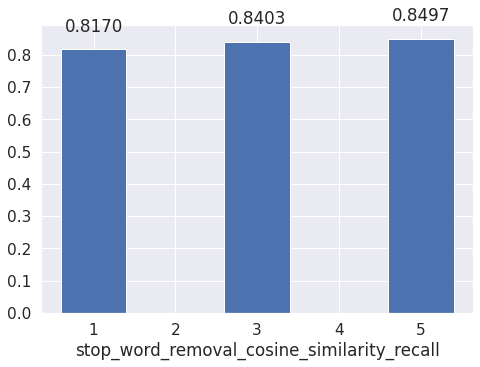

In [0]:
mean_recalls = []
recalls = {}
print(distance_criteria)
for k in K:
    aux = []
    for c in categories:
        recall = confusion_matrix[k][c-1][c-1] / np.sum(confusion_matrix[k][:, c-1])
        aux.append(recall)
        # print('knn recall with k={} for category={} ->'.format(k, c), recall)
    recalls[k] = aux
    print('knn mean recall with k={} ->'.format(k), sum(aux) / 4)
    mean_recalls.append(sum(aux) / 4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(K, mean_recalls)
ax.set_xlabel('{}_{}_recall'.format(nltk_method, distance_criteria))
autolabel(rects, ax)    

### Accuracy

cosine_similarity
knn accuracy with k=1 -> 0.817
knn accuracy with k=3 -> 0.8403333333333334
knn accuracy with k=5 -> 0.8496666666666667


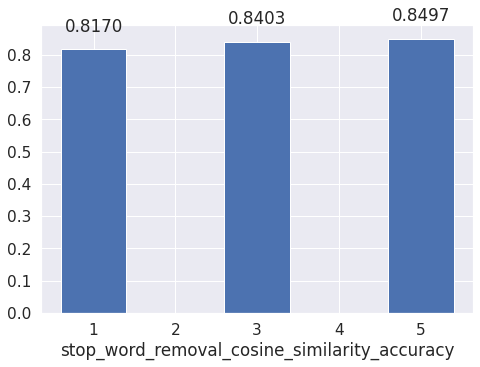

In [0]:
print(distance_criteria)
accuracies = []
for k in K:
    accuracy = np.sum(np.diag(confusion_matrix[k])) / np.sum(confusion_matrix[k])
    accuracies.append(accuracy)
    print('knn accuracy with k={} ->'.format(k), accuracy)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(K, accuracies)
ax.set_xlabel('{}_{}_accuracy'.format(nltk_method, distance_criteria))
autolabel(rects, ax)  

### macro F1 score

cosine_similarity
knn macro f1 score with k=1 -> 0.8171064383301347
knn macro f1 score with k=3 -> 0.8401827383848364
knn macro f1 score with k=5 -> 0.8492767603586111


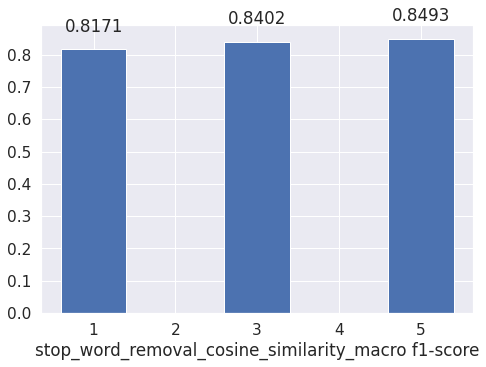

In [0]:
macro_f1_scores = []
print(distance_criteria)
for idx, k in enumerate(K):
    aux = []
    for c in categories:
        aux.append((2*precisions[k][c-1]*recalls[k][c-1]) / (precisions[k][c-1]+recalls[k][c-1]))
    
    macro_f1_scores.append(sum(aux) / 4)
    print('knn macro f1 score with k={} ->'.format(k), macro_f1_scores[idx])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(K, macro_f1_scores)
ax.set_xlabel('{}_{}_macro f1-score'.format(nltk_method, distance_criteria))
autolabel(rects, ax) 

In [0]:
ps.append(mean_precisions[-1])
rs.append(mean_recalls[-1])
acs.append(accuracies[-1])
f1s.append(macro_f1_scores[-1])
names.append('{}'.format(nltk_method))

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, ps)
ax.set_xlabel('precision')
autolabel(rects, ax) 

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, rs)
ax.set_xlabel('recall')
autolabel(rects, ax) 

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, acs)
ax.set_xlabel('accuracy')
autolabel(rects, ax) 

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, f1s)
ax.set_xlabel('macro f1 scores')
autolabel(rects, ax) 

# Naive Bayes

In [0]:
# candidate_alphas = [i / 10 for i in range(20)]

In [0]:
candidate_alphas = [0.2]
# ps = []
# rs = []
# acs = []
# fs = []
# names = []

In [0]:
alphas = []
for alpha in tqdm(candidate_alphas):
  conditional_probability = np.zeros((len(train_index), 4), dtype=np.float32) + alpha
  number_of_terms_in_category = np.zeros((len(categories)), dtype=np.float32)
  for idx, term in enumerate(train_index):
    for c in categories:
        conditional_probability[idx][c-1] += train_index[term].count_in_categories[c]
        number_of_terms_in_category[c-1] += train_index[term].count_in_categories[c]
  number_of_terms_in_category = number_of_terms_in_category + (alpha * len(train_index))
  conditional_probability = conditional_probability / number_of_terms_in_category
  prior = np.array([0.25, 0.25, 0.25, 0.25], dtype=np.float32)
  naive_results = []
  for test_doc_id, test_doc in enumerate(test_data):
      test_index = {}
      extract_terms(test_doc, test_doc_id, test_index)
      
      scores = np.copy(np.log10(prior))
      
      for idx, term in enumerate(train_index):
          if term in test_index:
              for c in categories:
                  scores[c-1] += np.log10(conditional_probability[idx][c-1])
      naive_results.append([np.argmax(scores)+1, test_doc['category']])
  naive_confusion_matrix = np.array([
      [0, 0, 0, 0],
      [0, 0, 0, 0],
      [0, 0, 0, 0],
      [0, 0, 0, 0],
  ])

  for result in naive_results:
      naive_confusion_matrix[result[0]-1][result[1]-1] += 1
  # print(distance_criteria, '\n\n')
  precisions = []
  for c in categories:
      precision = naive_confusion_matrix[c-1][c-1] / np.sum(naive_confusion_matrix[c-1])
      precisions.append(precision)
      
  recalls = []
  for c in categories:
      recall = naive_confusion_matrix[c-1][c-1] / np.sum(naive_confusion_matrix[:, c-1])
      recalls.append(recall)
      
  accuracy = np.sum(np.diag(naive_confusion_matrix)) / np.sum(naive_confusion_matrix)
  
  f1_scores = []
  for c in categories:
      f1_scores.append((2*precisions[c-1]*recalls[c-1]) / (precisions[c-1]+recalls[c-1]))

  macro_f1_scores = sum(f1_scores) / 4
  
  print("%.4f"%(sum(precisions)/4))
  print("%.4f"%(sum(recalls)/4))
  print("%.4f"%(accuracy))
  print("%.4f"%(sum(f1_scores) / 4))
  ps.append(sum(precisions)/4)
  rs.append(sum(recalls)/4)
  acs.append(accuracy)
  f1s.append(sum(f1_scores) / 4)
  names.append(nltk_method)
#   alphas.append(alpha)
#   plt.plot(alphas, ps)
#   plt.show()
#   plt.plot(alphas, rs)
#   plt.show()
#   plt.plot(alphas, acs)
#   plt.show()
#   plt.plot(alphas, fs)
#   plt.show()



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:22<00:00, 22.92s/it]

0.8910
0.8910
0.8910
0.8907


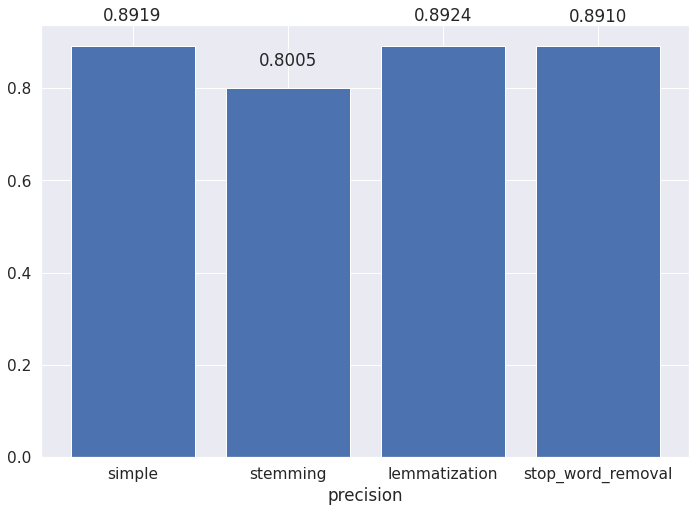

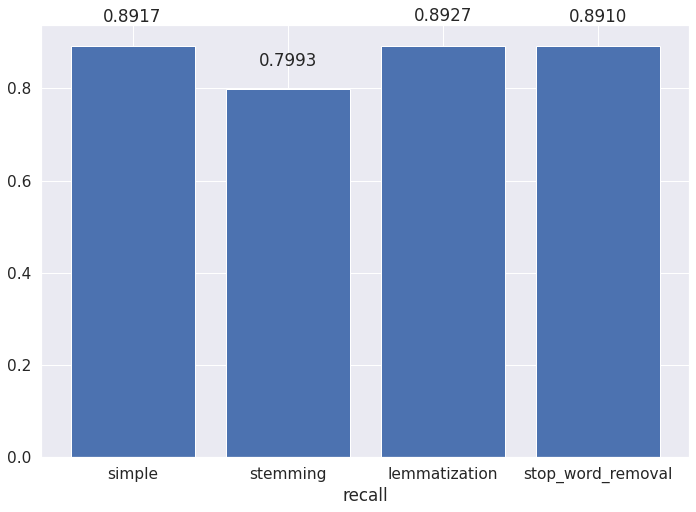

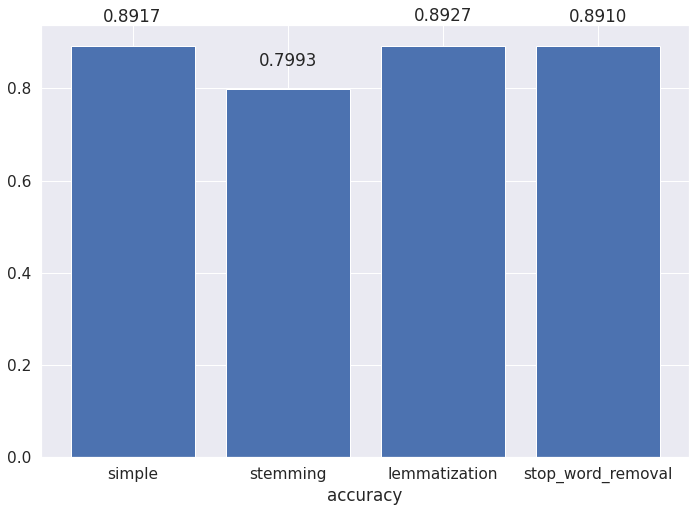

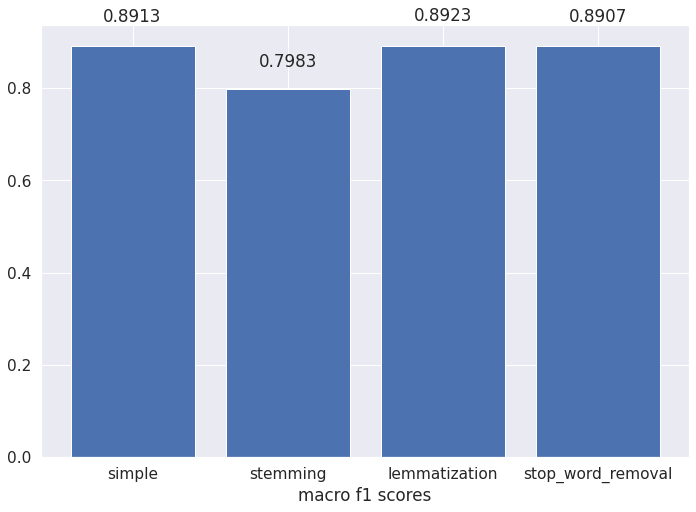

In [0]:
sn.set(font_scale=1.4)

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, ps)
ax.set_xlabel('precision')
autolabel(rects, ax) 

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, rs)
ax.set_xlabel('recall')
autolabel(rects, ax) 

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, acs)
ax.set_xlabel('accuracy')
autolabel(rects, ax) 

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
rects = ax.bar(names, f1s)
ax.set_xlabel('macro f1 scores')
autolabel(rects, ax) 

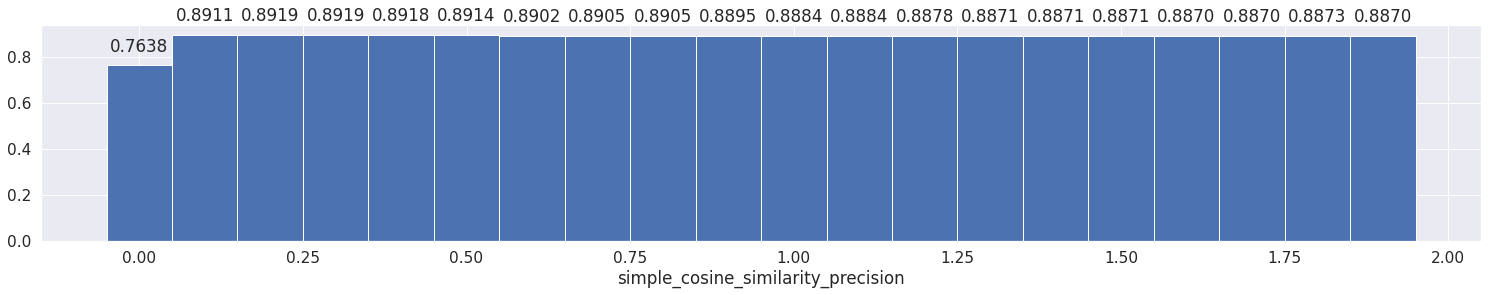

In [0]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_axes([0,0,1, 1])
rects = ax.bar(candidate_alphas, ps, width=0.1)
ax.set_xlabel('{}_{}_precision'.format(nltk_method, distance_criteria))
autolabel(rects, ax) 

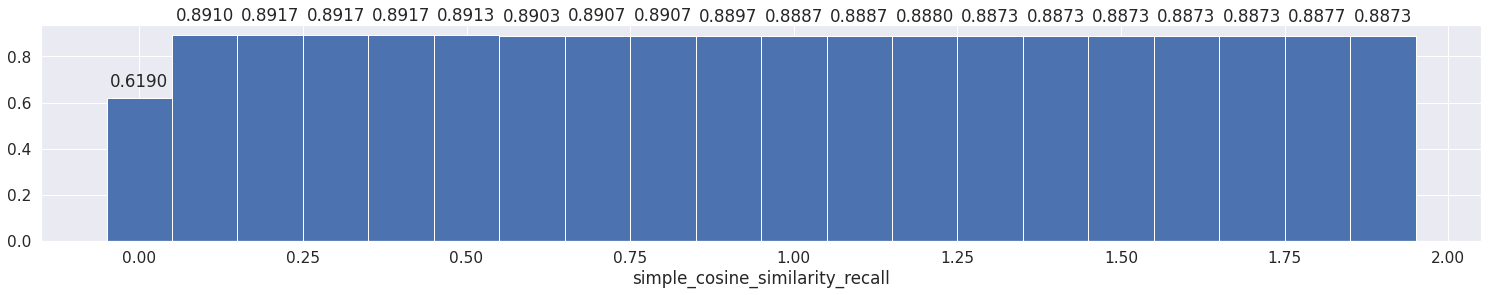

In [0]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_axes([0,0,1, 1])
rects = ax.bar(candidate_alphas, rs, width=0.1)
ax.set_xlabel('{}_{}_recall'.format(nltk_method, distance_criteria))
autolabel(rects, ax) 

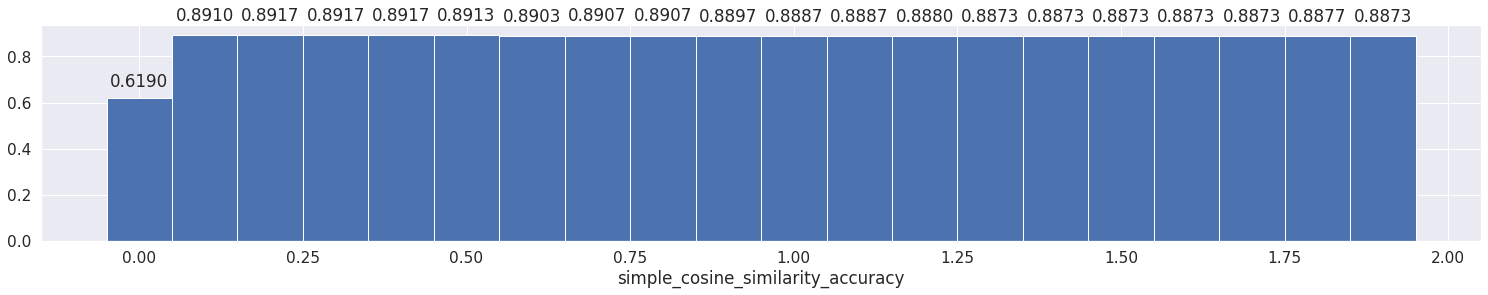

In [0]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_axes([0,0,1, 1])
rects = ax.bar(candidate_alphas, acs, width=0.1)
ax.set_xlabel('{}_{}_accuracy'.format(nltk_method, distance_criteria))
autolabel(rects, ax) 

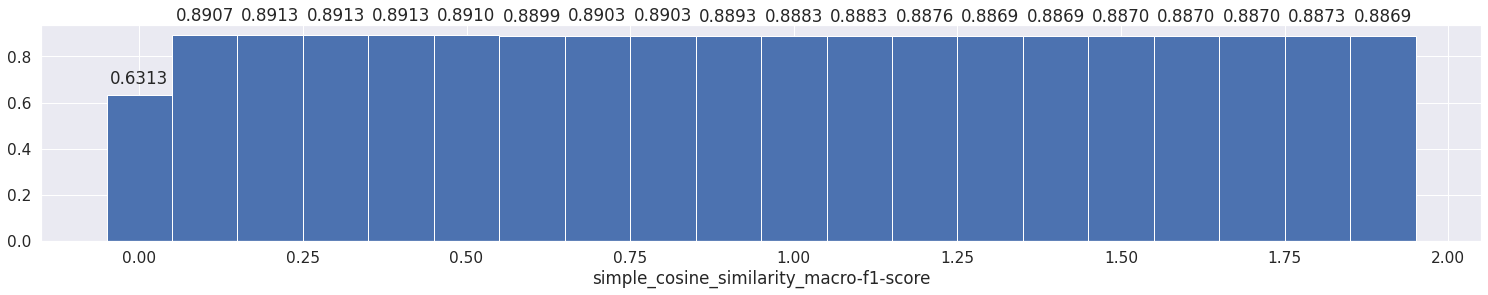

In [0]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_axes([0,0,1, 1])
rects = ax.bar(candidate_alphas, fs, width=0.1)
ax.set_xlabel('{}_{}_macro-f1-score'.format(nltk_method, distance_criteria))
autolabel(rects, ax) 

# SVM

In [0]:
Cs = [0.1, 1.0, 10.0]

c_matrix = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
], dtype=np.uint64)
confusion_matrix = {}

for c in Cs:
    confusion_matrix[c] = np.copy(c_matrix)

In [0]:
index = np.random.choice(train_matrix.shape[0], train_matrix.shape[0]//4, replace=False)  

3383.0149574279785


100%|██████████| 3000/3000 [00:00<00:00, 140171.46it/s]


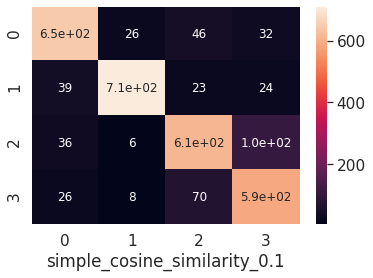

3372.9302277565002


100%|██████████| 3000/3000 [00:00<00:00, 139240.79it/s]


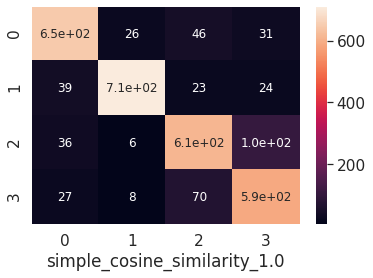

3397.4816002845764


100%|██████████| 3000/3000 [00:00<00:00, 138657.73it/s]


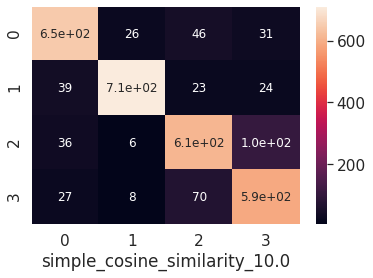

In [0]:
for i, c in enumerate(Cs):
    start = time.time()
    clf = svm.SVC(kernel='linear', C=c)
    clf.fit(train_matrix[index], train_labels[index])
    # save_pickle('{}{}_{}_svm.pickle'.format(base_dir, i+1, nltk_method), clf)
    print(time.time()-start)
    predict = clf.predict(test_matrix)
    for idx, category in tqdm(enumerate(predict), total=len(predict)):
        confusion_matrix[c][category-1][test_data[idx]['category']-1] += 1
    df_cm = pd.DataFrame(confusion_matrix[c], range(4), range(4))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
    plt.xlabel("{}_{}_{}".format(nltk_method, distance_criteria, c))
    plt.show()

In [0]:
save_pickle('{}svm_confusion_matrix.pickle'.format(base_dir), confusion_matrix)

file saved


In [0]:
confusion_matrix = load_pickle('{}svm_confusion_matrix.pickle'.format(base_dir))

file loaded


## Precision

cosine_similarity
knn mean precision with C=0.1 -> 0.8524605101696453
knn mean precision with C=1.0 -> 0.8524496994605419
knn mean precision with C=10.0 -> 0.8524496994605419


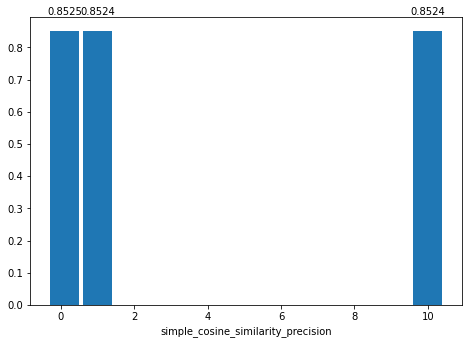

In [0]:
mean_precisions = []
precisions = {}
print(distance_criteria)
for C in Cs:
    aux = []
    for c in categories:
        precision = confusion_matrix[C][c-1][c-1] / np.sum(confusion_matrix[C][c-1])
        aux.append(precision)
    precisions[C] = aux
    mean_precisions.append(sum(aux) / 4)
    print('knn mean precision with C={} ->'.format(C), sum(aux) / 4)
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
rects = ax.bar(Cs, mean_precisions)
ax.set_xlabel('{}_{}_precision'.format(nltk_method, distance_criteria))
autolabel(rects, ax)

## Recall

cosine_similarity
knn mean recall with C=0.1 -> 0.853
knn mean recall with C=1.0 -> 0.853
knn mean recall with C=10.0 -> 0.853


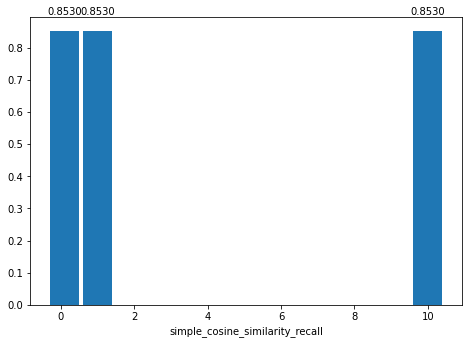

In [0]:
mean_recalls = []
recalls = {}
print(distance_criteria)
for C in Cs:
    aux = []
    for c in categories:
        recall = confusion_matrix[C][c-1][c-1] / np.sum(confusion_matrix[C][:, c-1])
        aux.append(recall)
        # print('knn recall with k={} for category={} ->'.format(k, c), recall)
    recalls[C] = aux
    print('knn mean recall with C={} ->'.format(C), sum(aux) / 4)
    mean_recalls.append(sum(aux) / 4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(Cs, mean_recalls)
ax.set_xlabel('{}_{}_recall'.format(nltk_method, distance_criteria))
autolabel(rects, ax)    

## Accuracy

cosine_similarity
knn accuracy with C=0.1 -> 0.853
knn accuracy with C=1.0 -> 0.853
knn accuracy with C=10.0 -> 0.853


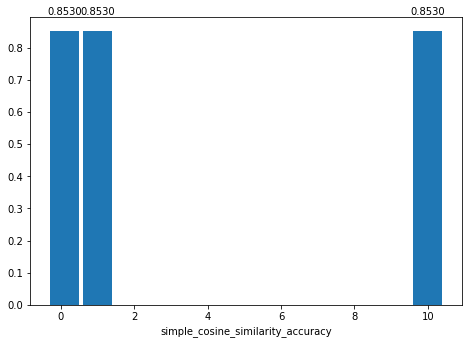

In [0]:
print(distance_criteria)
accuracies = []
for C in Cs:
    accuracy = np.sum(np.diag(confusion_matrix[C])) / np.sum(confusion_matrix[C])
    accuracies.append(accuracy)
    print('knn accuracy with C={} ->'.format(C), accuracy)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar(Cs, accuracies)
ax.set_xlabel('{}_{}_accuracy'.format(nltk_method, distance_criteria))
autolabel(rects, ax)  

# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
# index = np.random.choice(train_matrix.shape[0], train_matrix.shape[0]//3, replace=False)  
parameters = [[100, 100], [100, 50], [150, 100], [150, 50]]
for i, p in tqdm(enumerate(parameters), total=4):
    print(i)
    if i < 2:
        continue
    rf = RandomForestClassifier(n_estimators=p[0], oob_score=True, random_state=123456, max_depth=p[1])
    rf.fit(train_matrix, train_labels)
    save_pickle('{}{}_{}_rf.pickle'.format(base_dir, i+1, nltk_method), rf)

  0%|          | 0/4 [00:00<?, ?it/s]

0
1
2


 75%|███████▌  | 3/4 [22:20<07:26, 446.76s/it]

file saved
3


100%|██████████| 4/4 [39:22<00:00, 590.55s/it]

file saved


In [0]:
c_matrix = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
], dtype=np.uint64)
confusion_matrix = {}

for p in range(len(parameters)):
    confusion_matrix[p+1] = np.copy(c_matrix)

file loaded


100%|██████████| 3000/3000 [00:00<00:00, 149016.01it/s]


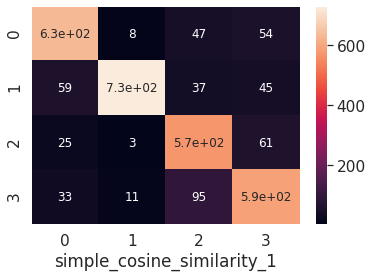

file loaded


100%|██████████| 3000/3000 [00:00<00:00, 136973.26it/s]


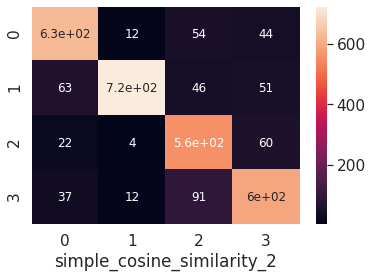

file loaded


100%|██████████| 3000/3000 [00:00<00:00, 119629.90it/s]


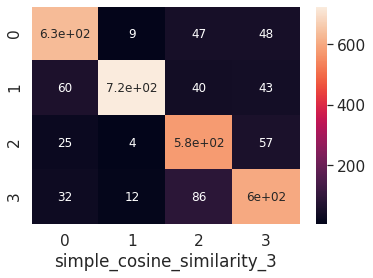

file loaded


100%|██████████| 3000/3000 [00:00<00:00, 142072.24it/s]


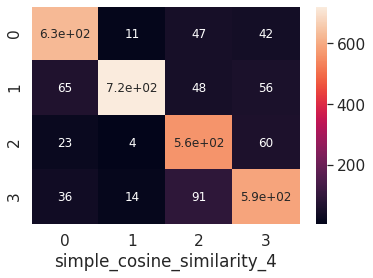

In [0]:
for p in range(len(parameters)):
    rf = load_pickle('{}{}_{}_rf.pickle'.format(base_dir, p+1, nltk_method))
    predict = rf.predict(test_matrix)
    for idx, category in tqdm(enumerate(predict), total=len(predict)):
        confusion_matrix[p+1][category-1][test_data[idx]['category']-1] += 1
    df_cm = pd.DataFrame(confusion_matrix[p+1], range(4), range(4))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
    plt.xlabel("{}_{}_{}".format(nltk_method, distance_criteria, p+1))
    plt.show()

## Precision

cosine_similarity
knn mean precision with p=1 -> 0.8413309064804213
knn mean precision with p=2 -> 0.8364332724959902
knn mean precision with p=3 -> 0.846707946312567
knn mean precision with p=4 -> 0.8365926490031091


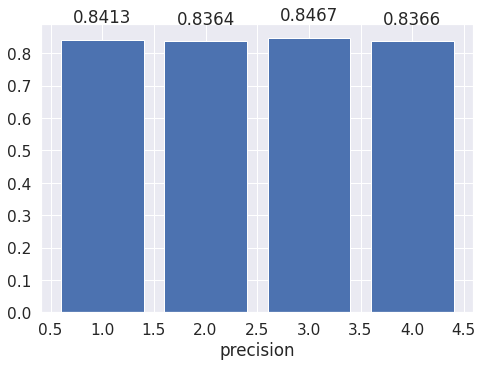

In [0]:
mean_precisions = []
precisions = {}
print(distance_criteria)
for p in range(len(parameters)):
    aux = []
    for c in categories:
        precision = confusion_matrix[p+1][c-1][c-1] / np.sum(confusion_matrix[p+1][c-1])
        aux.append(precision)
    precisions[p+1] = aux
    mean_precisions.append(sum(aux) / 4)
    print('knn mean precision with p={} ->'.format(p+1), sum(aux) / 4)
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
rects = ax.bar([1, 2, 3, 4], mean_precisions)
ax.set_xlabel('precision')
autolabel(rects, ax)

## Recall

cosine_similarity
knn mean recall with p=1 -> 0.8406666666666667
knn mean recall with p=2 -> 0.8346666666666667
knn mean recall with p=3 -> 0.8456666666666667
knn mean recall with p=4 -> 0.8343333333333334


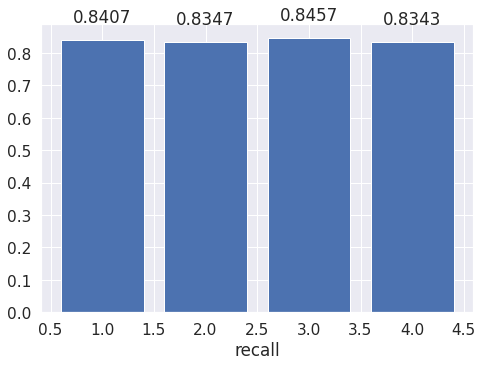

In [0]:
mean_recalls = []
recalls = {}
print(distance_criteria)
for p in range(len(parameters)):
    aux = []
    for c in categories:
        recall = confusion_matrix[p+1][c-1][c-1] / np.sum(confusion_matrix[p+1][:, c-1])
        aux.append(recall)
        # print('knn recall with k={} for category={} ->'.format(k, c), recall)
    recalls[p+1] = aux
    print('knn mean recall with p={} ->'.format(p+1), sum(aux) / 4)
    mean_recalls.append(sum(aux) / 4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar([1, 2, 3, 4], mean_recalls)
ax.set_xlabel('recall')
autolabel(rects, ax)    

## Accuracy

cosine_similarity
knn accuracy with p=1 -> 0.8406666666666667
knn accuracy with p=2 -> 0.8346666666666667
knn accuracy with p=3 -> 0.8456666666666667
knn accuracy with p=4 -> 0.8343333333333334


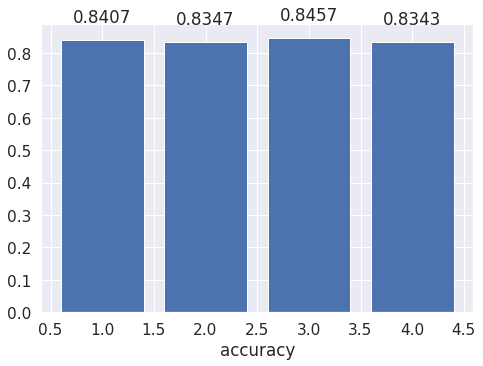

In [0]:
print(distance_criteria)
accuracies = []
for p in range(len(parameters)):
    accuracy = np.sum(np.diag(confusion_matrix[p+1])) / np.sum(confusion_matrix[p+1])
    accuracies.append(accuracy)
    print('knn accuracy with p={} ->'.format(p+1), accuracy)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects = ax.bar([1, 2, 3, 4], accuracies)
ax.set_xlabel('accuracy')
autolabel(rects, ax)  

# K means

In [0]:
def get_distances(centroid, points):
    return np.linalg.norm(points - centroid, axis=1)

def initialize_clusters(points, k):
    return 

In [0]:
k = 4
maxiter = 150

centroids = train_matrix[np.random.randint(train_matrix.shape[0], size=k)]    


classes = np.zeros(train_matrix.shape[0], dtype=np.uint8)
distances = np.zeros([train_matrix.shape[0], k], dtype=np.float64)

  0%|          | 0/150 [00:00<?, ?it/s]

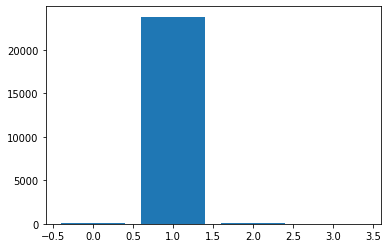

  1%|          | 1/150 [00:14<35:07, 14.15s/it]

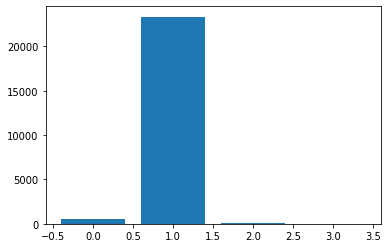

  1%|▏         | 2/150 [00:25<33:07, 13.43s/it]

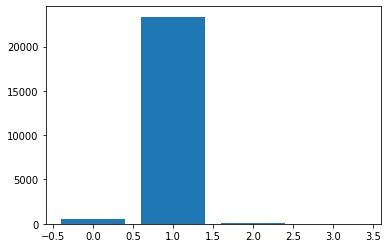

  2%|▏         | 3/150 [00:37<31:37, 12.90s/it]

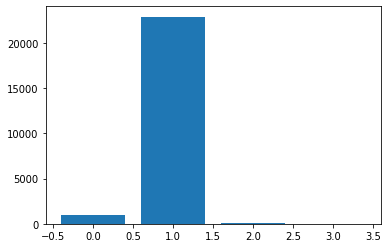

  3%|▎         | 4/150 [00:49<30:23, 12.49s/it]

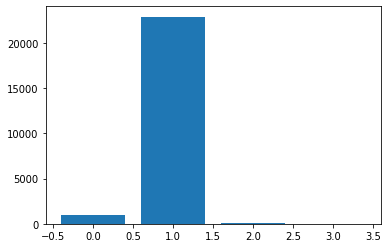

  3%|▎         | 5/150 [01:00<29:31, 12.22s/it]

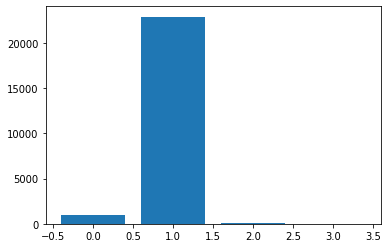

  4%|▍         | 6/150 [01:12<28:48, 12.00s/it]

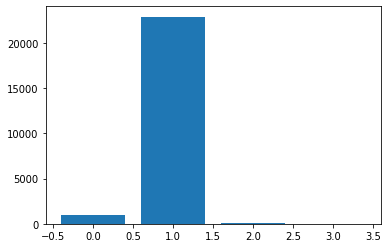

  5%|▍         | 7/150 [01:23<28:17, 11.87s/it]

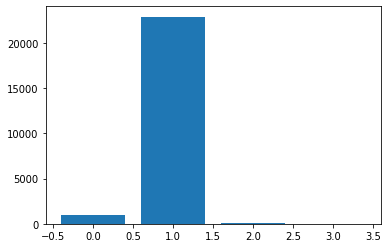

  5%|▌         | 8/150 [01:35<27:50, 11.77s/it]

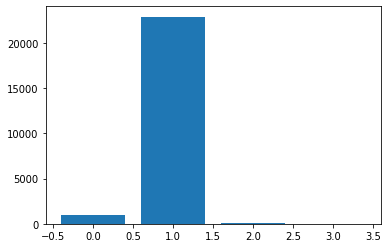

  6%|▌         | 9/150 [01:46<27:30, 11.71s/it]

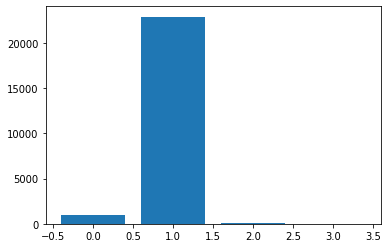

  7%|▋         | 10/150 [01:58<27:13, 11.67s/it]

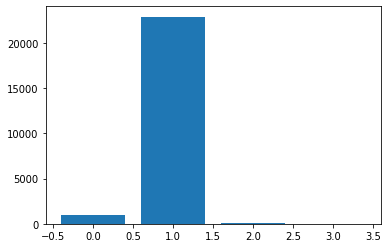

  7%|▋         | 11/150 [02:10<27:02, 11.67s/it]

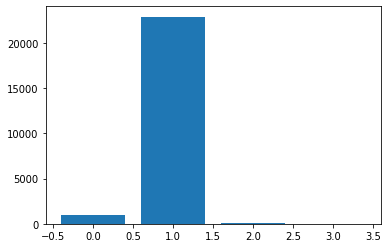

  8%|▊         | 12/150 [02:21<26:52, 11.69s/it]

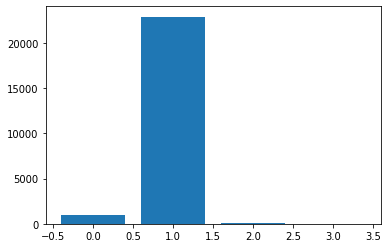

  9%|▊         | 13/150 [02:33<26:42, 11.70s/it]

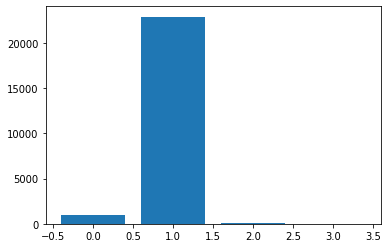

  9%|▉         | 14/150 [02:45<26:21, 11.63s/it]

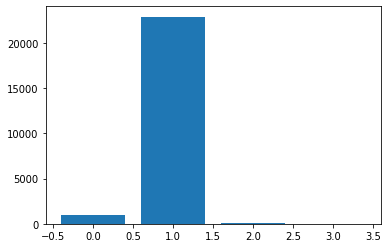

 10%|█         | 15/150 [02:56<26:07, 11.61s/it]

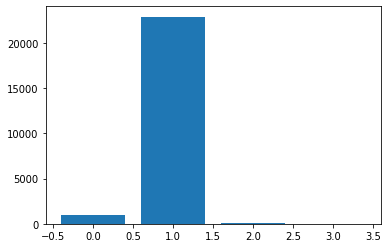

 11%|█         | 16/150 [03:08<25:57, 11.62s/it]

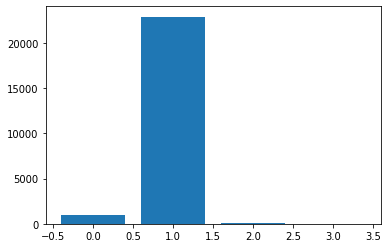

 11%|█▏        | 17/150 [03:19<25:42, 11.60s/it]

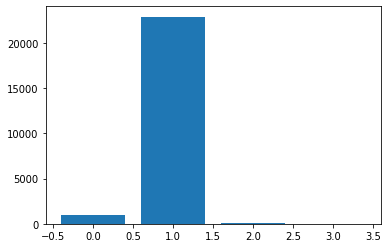

 12%|█▏        | 18/150 [03:31<25:29, 11.59s/it]

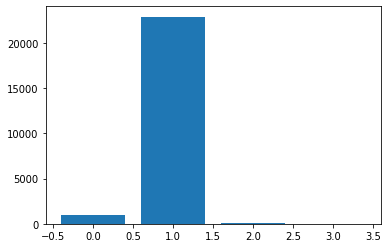

 13%|█▎        | 19/150 [03:42<25:13, 11.55s/it]

KeyboardInterrupt: ignored

In [0]:
for i in tqdm(range(maxiter)):
    
    for i, c in enumerate(centroids):
        distances[:, i] = get_distances(c, train_matrix)

    classes = np.argmin(distances, axis=1)
    
    for c in range(k):
        centroids[c] = np.mean(train_matrix[classes == c], 0)
    plt.bar(list(Counter(classes).keys()), list(Counter(classes).values()))
    plt.show()

In [0]:
np.save('{}k_means_classes.npy'.format(base_dir), classes)

In [0]:
feat_cols = [ 'pixel'+str(i) for i in range(train_matrix.shape[1]) ]
df = pd.DataFrame(train_matrix,columns=feat_cols)
aux = classes+1
df['y'] = aux
df['true_y'] = train_labels
df['label'] = df['y'].apply(lambda i: str(i))

In [0]:
dfs = []
for i in range(1, 5):
    dfs.append(df.loc[df['y'] == i][:200])

In [0]:
res_df = pd.concat(dfs)

In [0]:
from sklearn.manifold import TSNE

In [0]:
# np.random.seed(42)
# rndperm = np.random.permutation(res_df.shape[0])

In [0]:
# N = len(res_df)
# res_df_subset = res_df.loc[rndperm[:N],:].copy()
data_subset = res_df[feat_cols].values

In [0]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 526 samples in 2.693s...
[t-SNE] Computed neighbors for 526 samples in 31.837s...
[t-SNE] Computed conditional probabilities for sample 526 / 526
[t-SNE] Mean sigma: 6.005122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 186.466125
[t-SNE] KL divergence after 5000 iterations: 2.106479
t-SNE done! Time elapsed: 84.77260828018188 seconds


In [0]:
res_df['tsne-3d-one'] = tsne_results[:,0]
res_df['tsne-3d-two'] = tsne_results[:,1]
res_df['tsne-3d-three'] = tsne_results[:,2]


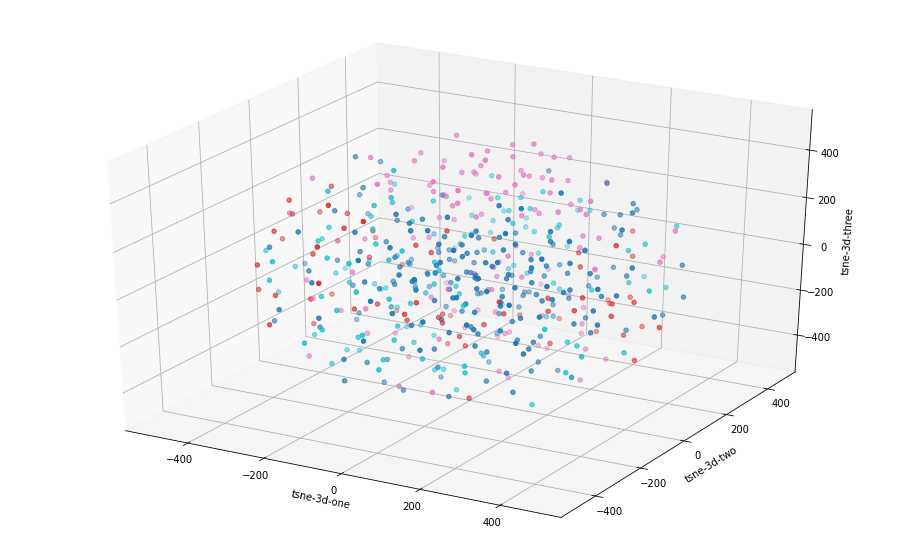

In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=res_df['tsne-3d-one'], 
    ys=res_df['tsne-3d-two'], 
    zs=res_df['tsne-3d-three'], 
    c=res_df['true_y'], 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

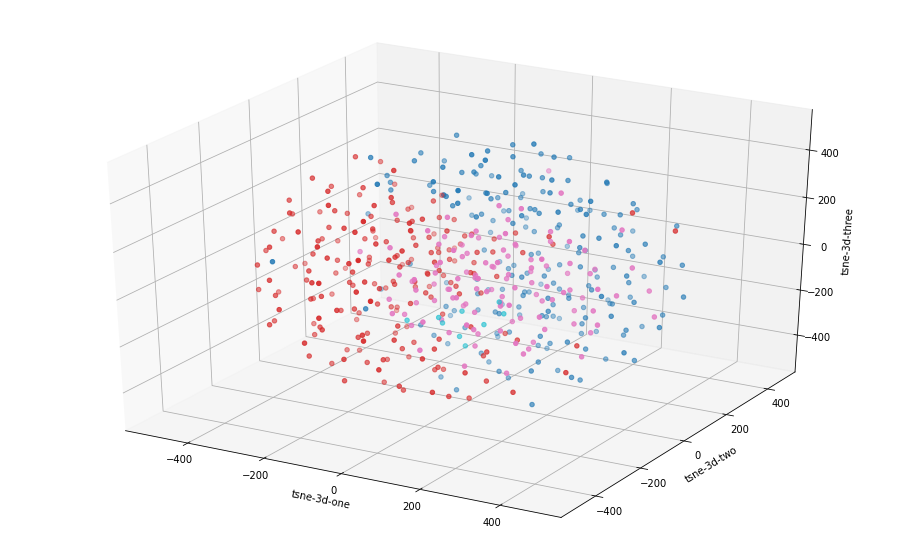

In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=res_df['tsne-3d-one'], 
    ys=res_df['tsne-3d-two'], 
    zs=res_df['tsne-3d-three'], 
    c=res_df["y"], 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

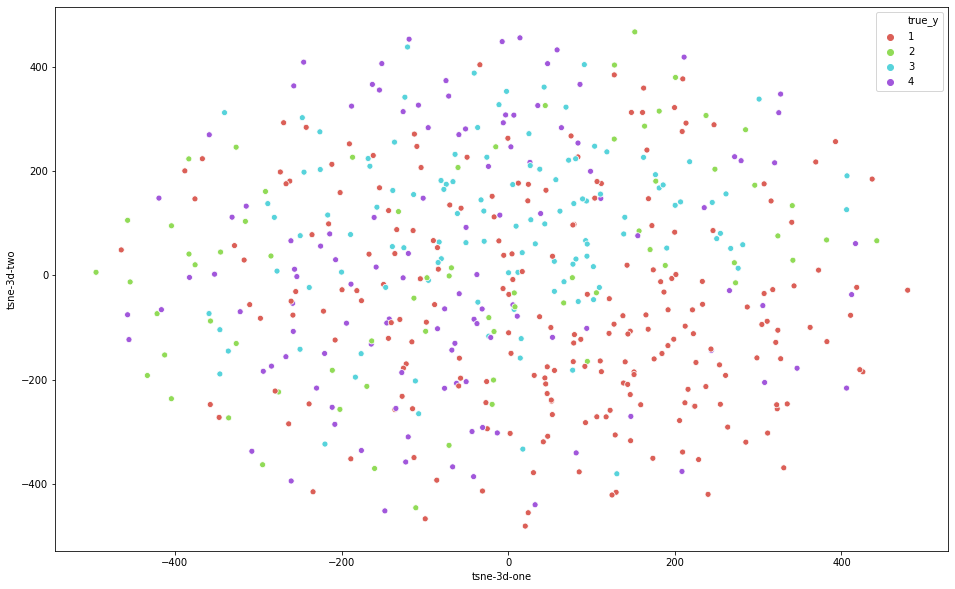

In [0]:

plt.figure(figsize=(16,10))
sn.scatterplot(
    x="tsne-3d-one", y="tsne-3d-two",
    hue="true_y",
    palette=sn.color_palette("hls", 4),
    data=res_df,
    legend="full",
    alpha=1,
)




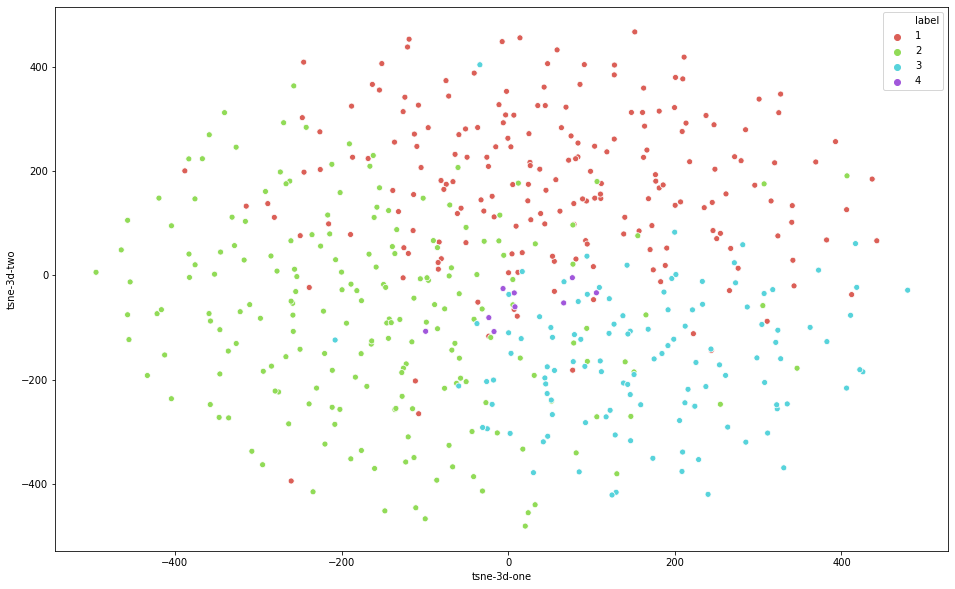

In [0]:

plt.figure(figsize=(16,10))
sn.scatterplot(
    x="tsne-3d-one", y="tsne-3d-two",
    hue="label",
    palette=sn.color_palette("hls", 4),
    data=res_df,
    legend="full",
    alpha=1,
)




# Word2Vec

In [0]:
import gensim

In [0]:
docs = []
for doc in tqdm(training_data):
    category = doc['category']
    body = doc['body']
    title = doc['title']
    body_words = re.findall(r"[\w']+", body)
    title_words = re.findall(r"[\w']+", title)
    words = body_words + title_words
    docs.append(words)


100%|██████████| 24000/24000 [00:00<00:00, 59827.78it/s]


In [0]:
embed_dim = 190
window = 9
model = gensim.models.Word2Vec(docs, min_count = 1, size = embed_dim, window = window, sg = 1)

In [0]:
w2v_docs = np.zeros((len(docs), embed_dim*2))
for idx, doc in enumerate(docs):
    w2v_docs[idx] = np.concatenate((np.amin(model.wv[doc], axis=0), np.amax(model.wv[doc], axis=0)))

In [0]:
def get_distances(centroid, points):
    return np.linalg.norm(points - centroid, axis=1)

def initialize_clusters(points, k):
    return 

In [0]:
k = 4
maxiter = 150

centroids = w2v_docs[np.random.randint(w2v_docs.shape[0], size=k)]    


classes = np.zeros(w2v_docs.shape[0], dtype=np.uint8)
distances = np.zeros([w2v_docs.shape[0], k], dtype=np.float64)





  0%|          | 0/150 [00:00<?, ?it/s]

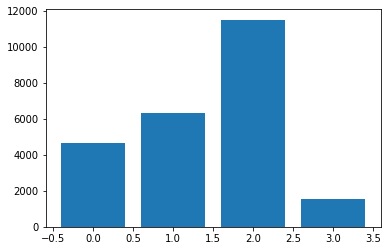





  1%|          | 1/150 [00:00<00:52,  2.82it/s]

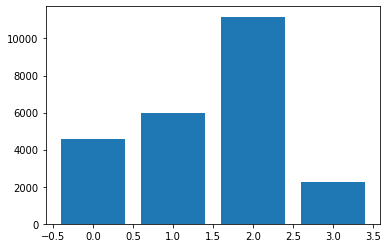





  1%|▏         | 2/150 [00:00<00:51,  2.87it/s]

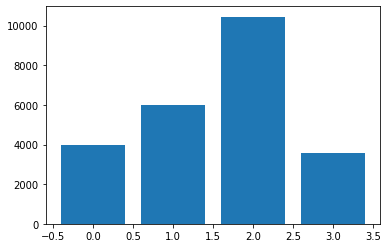





  2%|▏         | 3/150 [00:01<00:50,  2.91it/s]

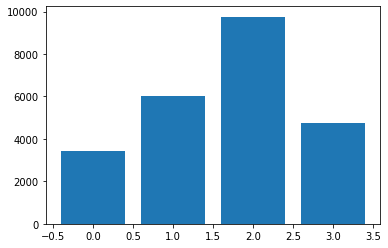





  3%|▎         | 4/150 [00:01<00:50,  2.92it/s]

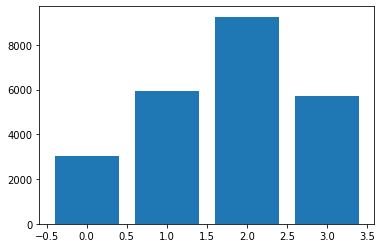





  3%|▎         | 5/150 [00:01<00:49,  2.94it/s]

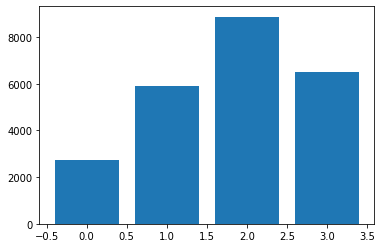





  4%|▍         | 6/150 [00:02<00:48,  2.95it/s]

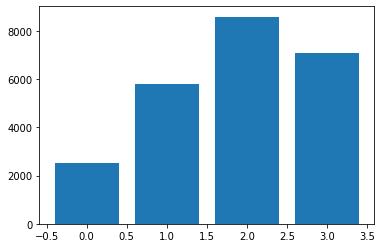





  5%|▍         | 7/150 [00:02<00:48,  2.97it/s]

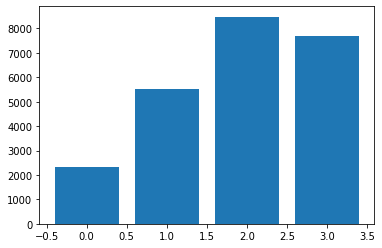





  5%|▌         | 8/150 [00:02<00:48,  2.92it/s]

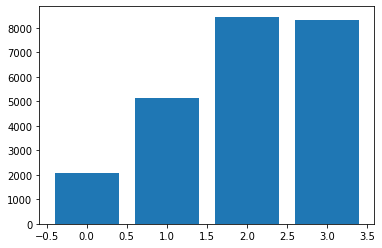





  6%|▌         | 9/150 [00:03<00:48,  2.91it/s]

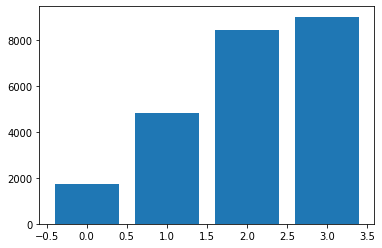





  7%|▋         | 10/150 [00:03<00:48,  2.91it/s]

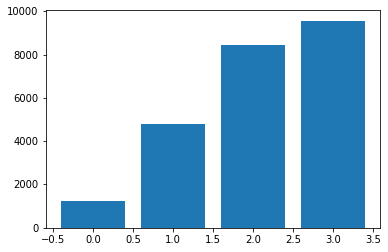





  7%|▋         | 11/150 [00:04<01:05,  2.13it/s]

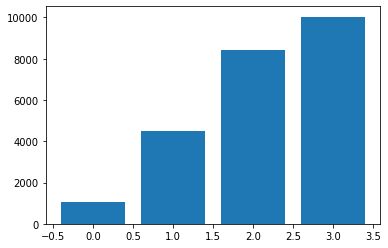





  8%|▊         | 12/150 [00:04<00:59,  2.32it/s]

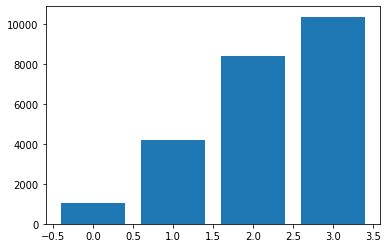





  9%|▊         | 13/150 [00:04<00:55,  2.48it/s]

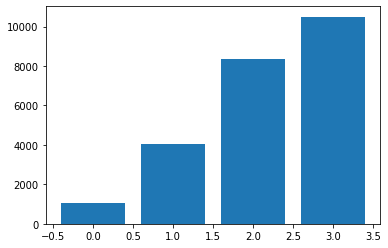





  9%|▉         | 14/150 [00:05<00:52,  2.59it/s]

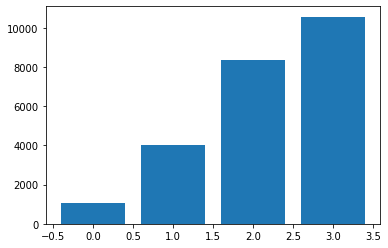





 10%|█         | 15/150 [00:05<00:50,  2.68it/s]

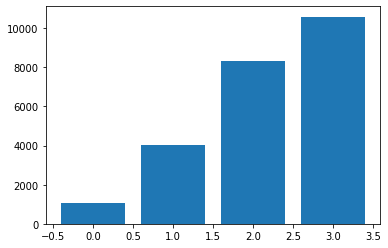





 11%|█         | 16/150 [00:05<00:48,  2.74it/s]

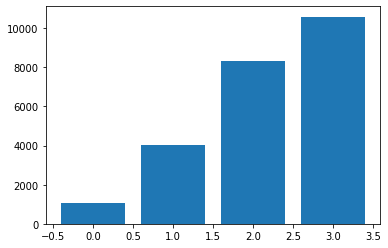





 11%|█▏        | 17/150 [00:06<00:47,  2.78it/s]

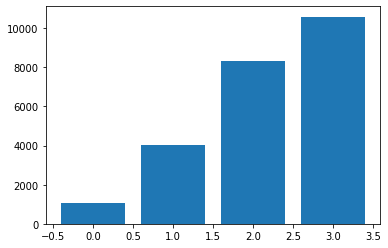





 12%|█▏        | 18/150 [00:06<00:46,  2.83it/s]

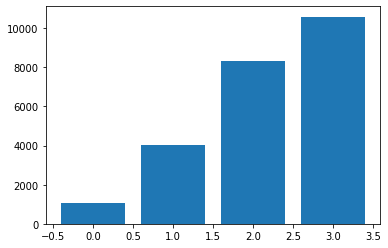





 13%|█▎        | 19/150 [00:06<00:45,  2.87it/s]

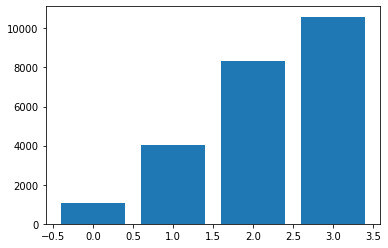





 13%|█▎        | 20/150 [00:07<00:45,  2.86it/s]

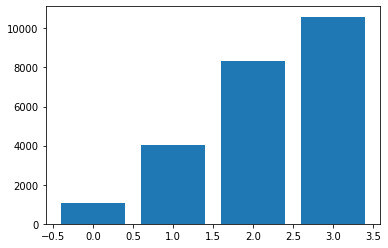





 14%|█▍        | 21/150 [00:07<00:44,  2.87it/s]

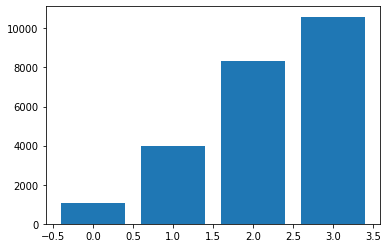





 15%|█▍        | 22/150 [00:07<00:44,  2.89it/s]

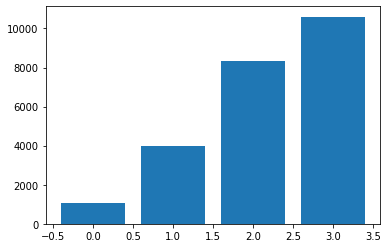





 15%|█▌        | 23/150 [00:08<00:43,  2.91it/s]

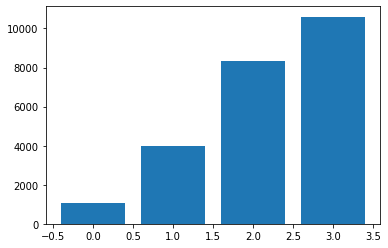





 16%|█▌        | 24/150 [00:08<00:43,  2.92it/s]

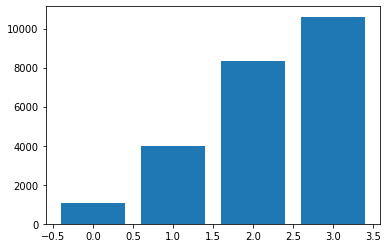





 17%|█▋        | 25/150 [00:08<00:42,  2.95it/s]

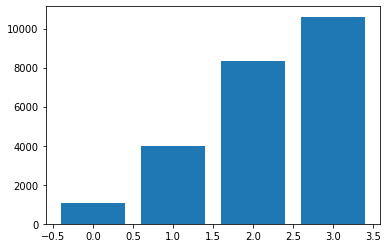





 17%|█▋        | 26/150 [00:09<00:42,  2.94it/s]

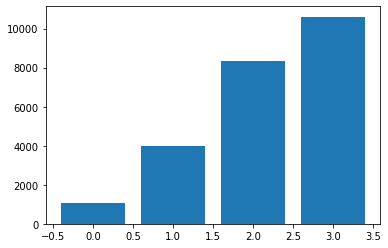





 18%|█▊        | 27/150 [00:09<00:42,  2.92it/s]

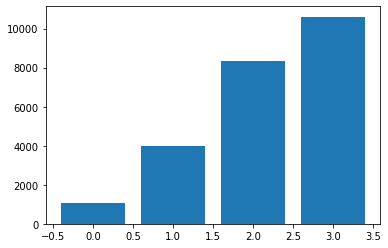





 19%|█▊        | 28/150 [00:09<00:41,  2.92it/s]

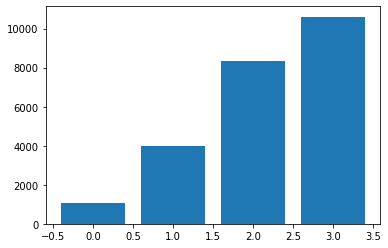





 19%|█▉        | 29/150 [00:10<00:41,  2.91it/s]

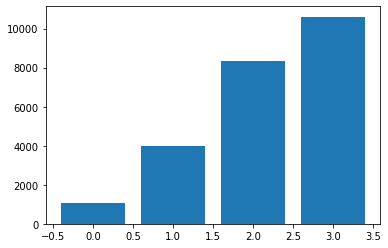





 20%|██        | 30/150 [00:10<00:41,  2.91it/s]

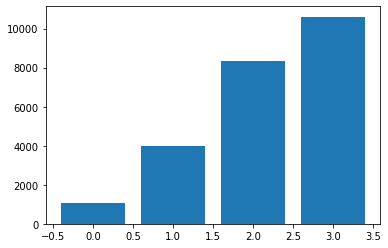





 21%|██        | 31/150 [00:11<00:40,  2.91it/s]

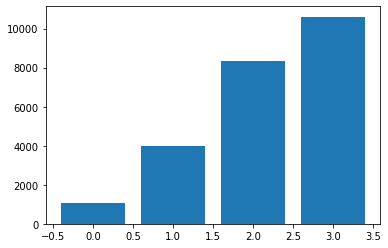





 21%|██▏       | 32/150 [00:11<00:40,  2.90it/s]

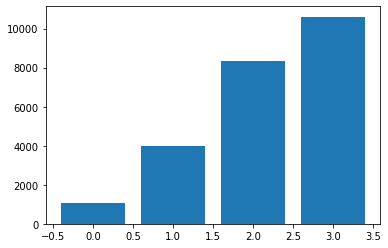





 22%|██▏       | 33/150 [00:11<00:40,  2.86it/s]

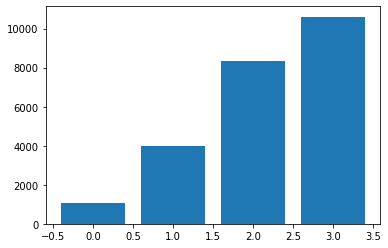





 23%|██▎       | 34/150 [00:12<00:40,  2.86it/s]

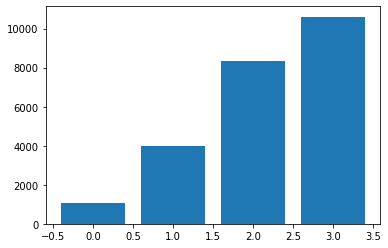





 23%|██▎       | 35/150 [00:12<00:39,  2.88it/s]

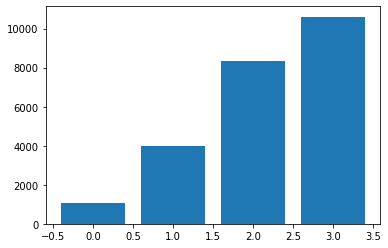





 24%|██▍       | 36/150 [00:12<00:39,  2.90it/s]

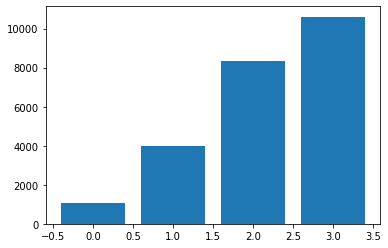





 25%|██▍       | 37/150 [00:13<00:38,  2.92it/s]

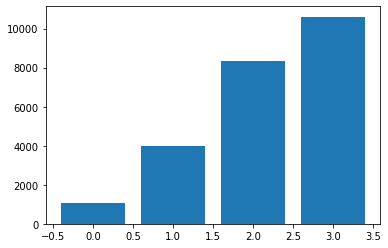





 25%|██▌       | 38/150 [00:13<00:38,  2.92it/s]

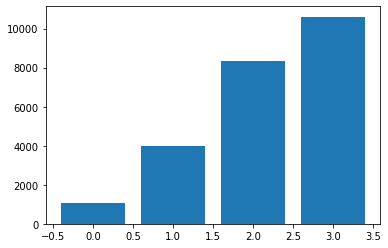





 26%|██▌       | 39/150 [00:13<00:38,  2.92it/s]

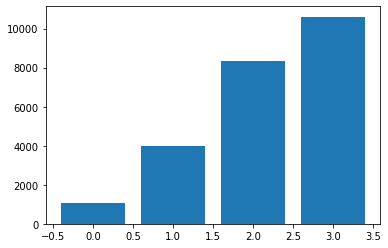





 27%|██▋       | 40/150 [00:14<00:37,  2.91it/s]

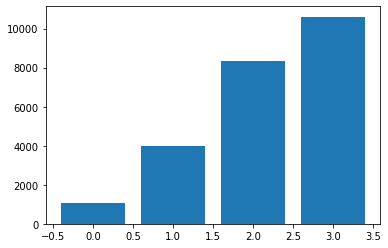





 27%|██▋       | 41/150 [00:14<00:37,  2.91it/s]

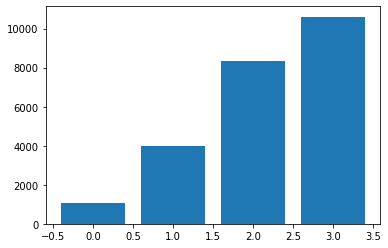





 28%|██▊       | 42/150 [00:14<00:36,  2.92it/s]

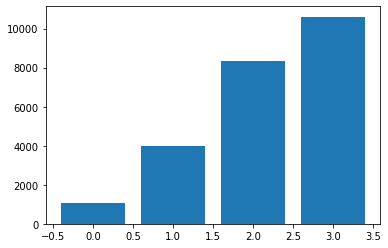





 29%|██▊       | 43/150 [00:15<00:36,  2.94it/s]

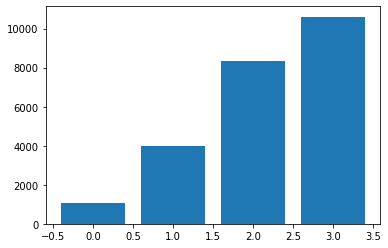





 29%|██▉       | 44/150 [00:15<00:36,  2.93it/s]

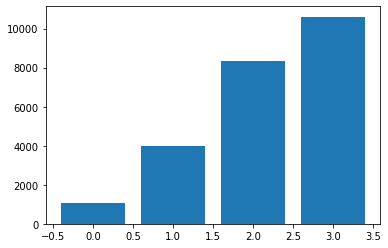





 30%|███       | 45/150 [00:15<00:35,  2.93it/s]

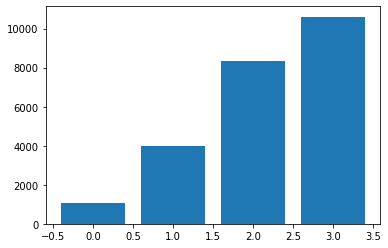





 31%|███       | 46/150 [00:16<00:35,  2.94it/s]

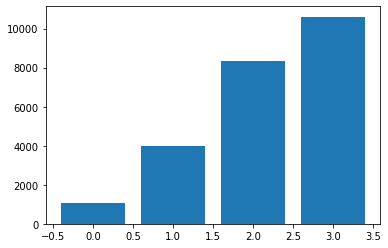





 31%|███▏      | 47/150 [00:16<00:34,  2.94it/s]

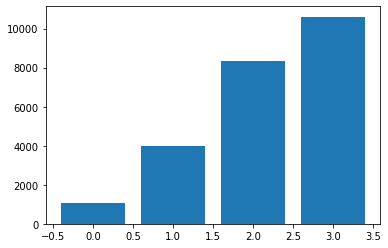





 32%|███▏      | 48/150 [00:16<00:34,  2.94it/s]

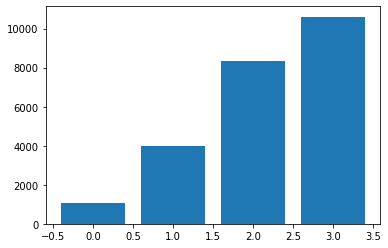





 33%|███▎      | 49/150 [00:17<00:34,  2.94it/s]

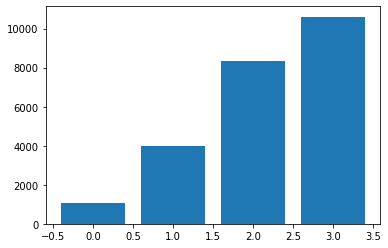





 33%|███▎      | 50/150 [00:17<00:34,  2.93it/s]

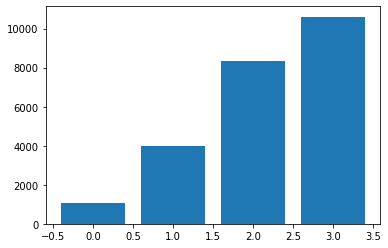





 34%|███▍      | 51/150 [00:17<00:33,  2.94it/s]

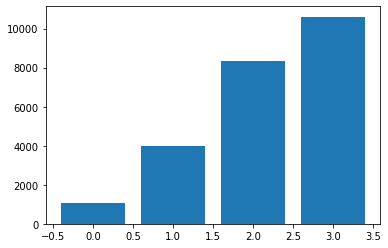





 35%|███▍      | 52/150 [00:18<00:33,  2.96it/s]

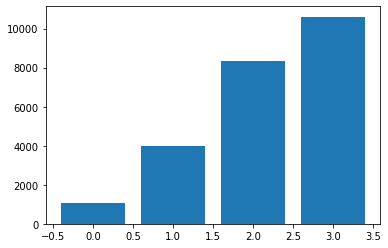





 35%|███▌      | 53/150 [00:18<00:32,  2.98it/s]

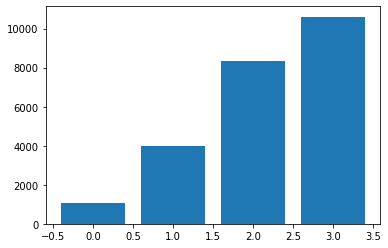





 36%|███▌      | 54/150 [00:18<00:32,  2.99it/s]

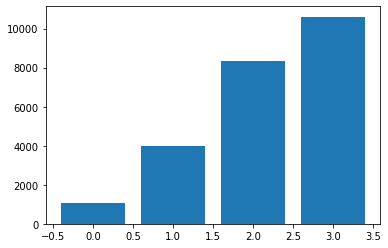





 37%|███▋      | 55/150 [00:19<00:31,  2.97it/s]

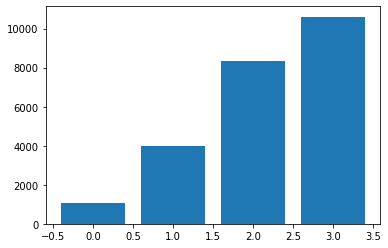





 37%|███▋      | 56/150 [00:19<00:31,  2.96it/s]

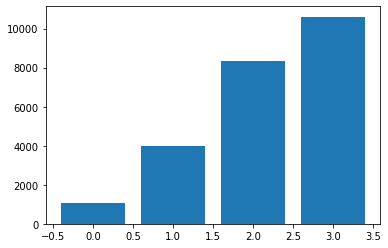





 38%|███▊      | 57/150 [00:19<00:31,  2.95it/s]

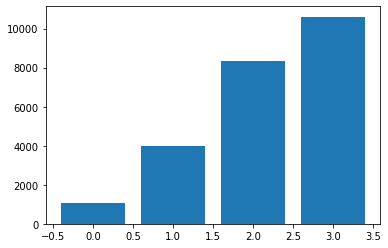





 39%|███▊      | 58/150 [00:20<00:31,  2.94it/s]

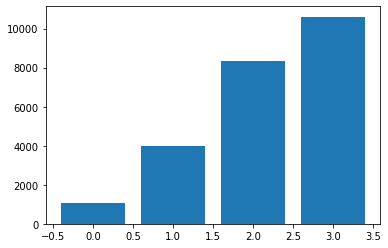





 39%|███▉      | 59/150 [00:20<00:30,  2.95it/s]

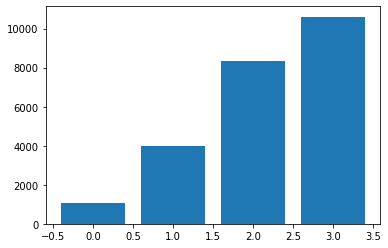





 40%|████      | 60/150 [00:20<00:30,  2.96it/s]

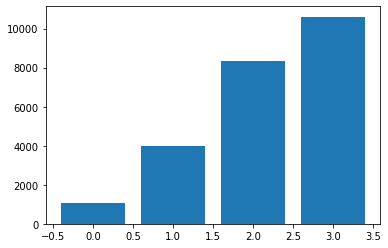





 41%|████      | 61/150 [00:21<00:30,  2.95it/s]

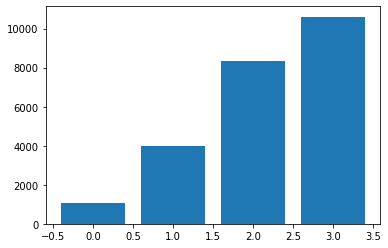





 41%|████▏     | 62/150 [00:21<00:29,  2.96it/s]

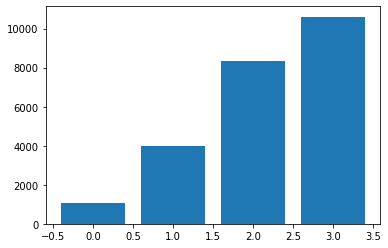





 42%|████▏     | 63/150 [00:22<00:41,  2.11it/s]

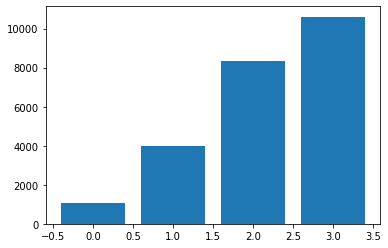





 43%|████▎     | 64/150 [00:22<00:37,  2.31it/s]

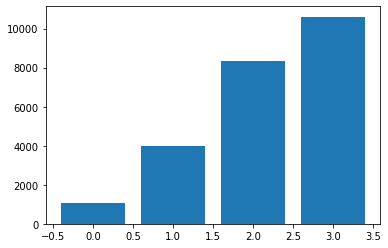





 43%|████▎     | 65/150 [00:23<00:34,  2.46it/s]

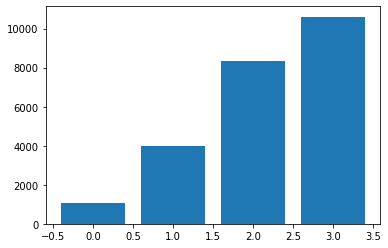





 44%|████▍     | 66/150 [00:23<00:32,  2.58it/s]

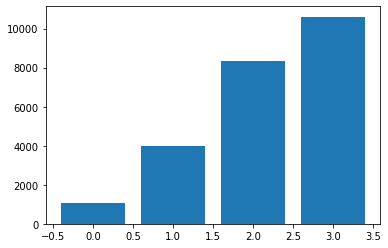





 45%|████▍     | 67/150 [00:23<00:30,  2.68it/s]

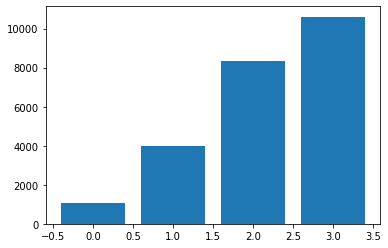





 45%|████▌     | 68/150 [00:24<00:29,  2.77it/s]

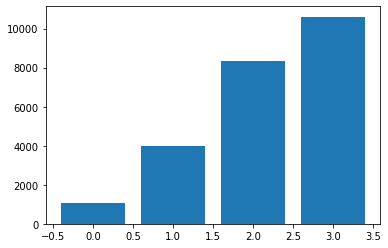





 46%|████▌     | 69/150 [00:24<00:28,  2.82it/s]

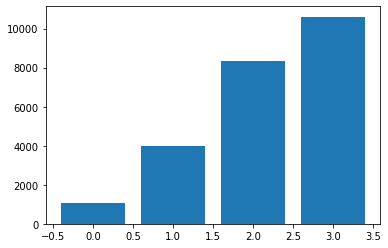





 47%|████▋     | 70/150 [00:24<00:27,  2.88it/s]

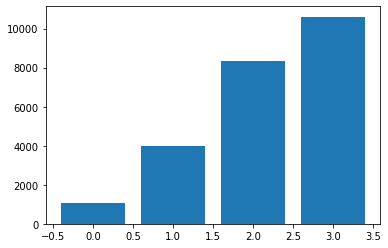





 47%|████▋     | 71/150 [00:25<00:27,  2.90it/s]

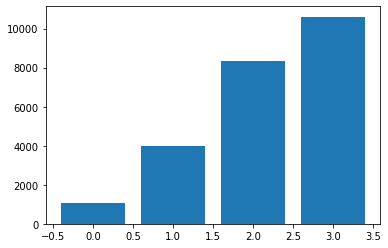





 48%|████▊     | 72/150 [00:25<00:26,  2.91it/s]

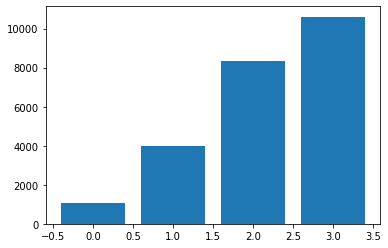





 49%|████▊     | 73/150 [00:25<00:26,  2.92it/s]

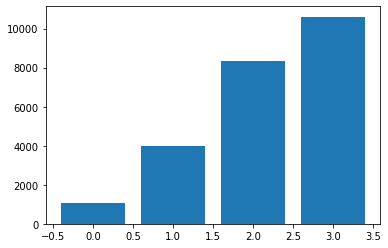





 49%|████▉     | 74/150 [00:26<00:25,  2.93it/s]

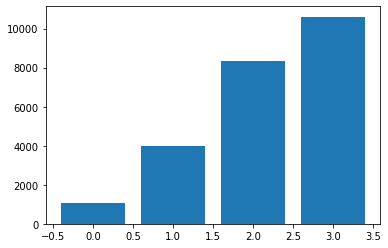





 50%|█████     | 75/150 [00:26<00:25,  2.94it/s]

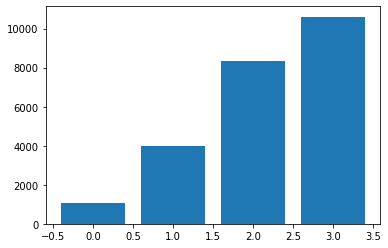





 51%|█████     | 76/150 [00:26<00:25,  2.95it/s]

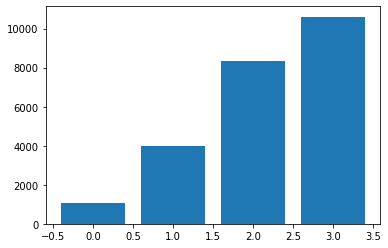





 51%|█████▏    | 77/150 [00:27<00:24,  2.94it/s]

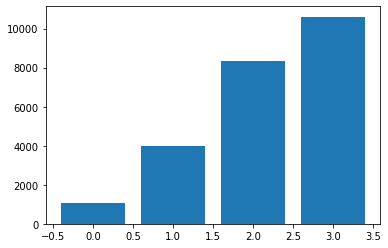





 52%|█████▏    | 78/150 [00:27<00:24,  2.95it/s]

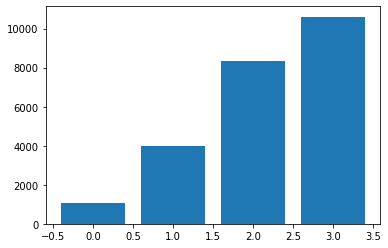





 53%|█████▎    | 79/150 [00:27<00:24,  2.96it/s]

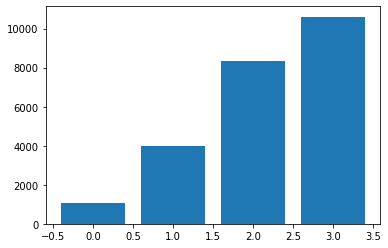





 53%|█████▎    | 80/150 [00:28<00:23,  2.94it/s]

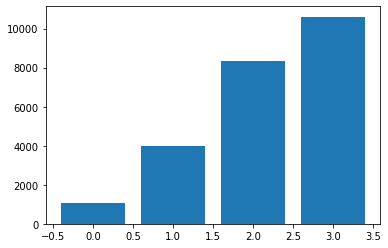





 54%|█████▍    | 81/150 [00:28<00:23,  2.89it/s]

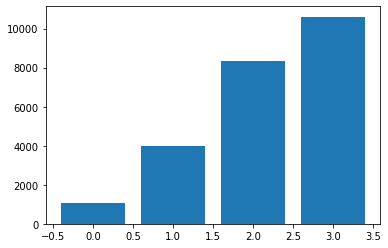





 55%|█████▍    | 82/150 [00:28<00:23,  2.90it/s]

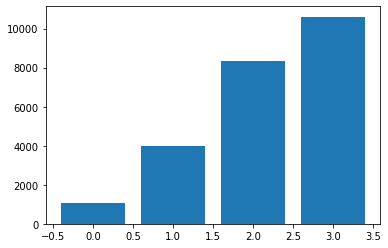





 55%|█████▌    | 83/150 [00:29<00:23,  2.91it/s]

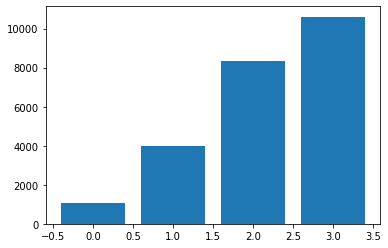





 56%|█████▌    | 84/150 [00:29<00:22,  2.92it/s]

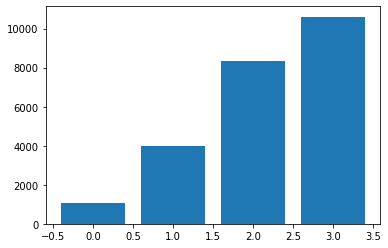





 57%|█████▋    | 85/150 [00:29<00:22,  2.94it/s]

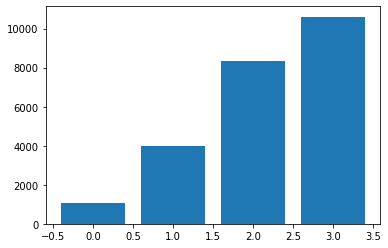





 57%|█████▋    | 86/150 [00:30<00:21,  2.91it/s]

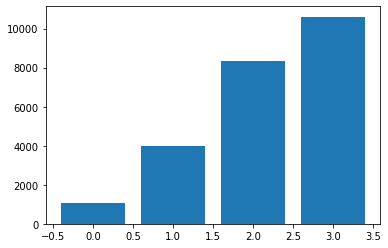





 58%|█████▊    | 87/150 [00:30<00:21,  2.94it/s]

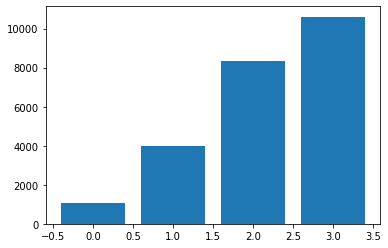





 59%|█████▊    | 88/150 [00:30<00:21,  2.95it/s]

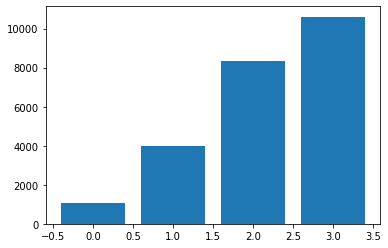





 59%|█████▉    | 89/150 [00:31<00:20,  2.92it/s]

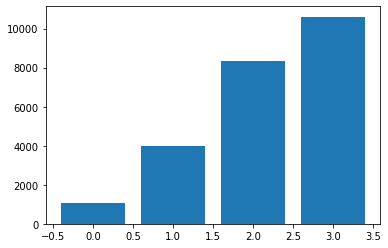





 60%|██████    | 90/150 [00:31<00:20,  2.90it/s]

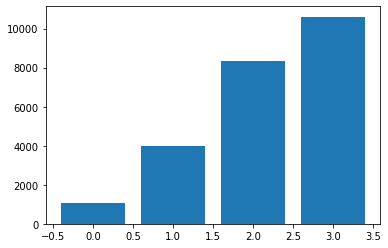





 61%|██████    | 91/150 [00:31<00:20,  2.91it/s]

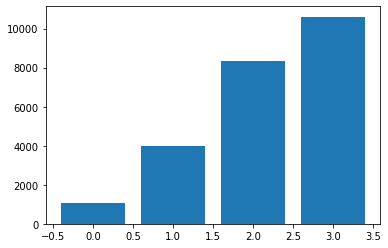





 61%|██████▏   | 92/150 [00:32<00:19,  2.91it/s]

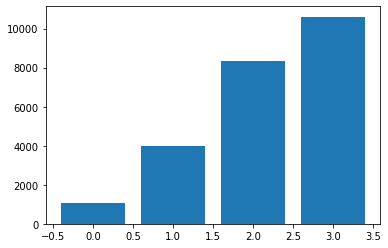





 62%|██████▏   | 93/150 [00:32<00:19,  2.92it/s]

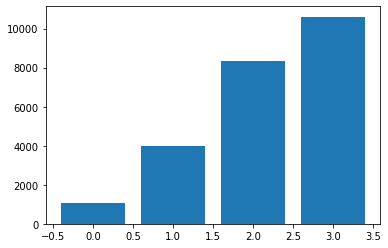





 63%|██████▎   | 94/150 [00:32<00:19,  2.89it/s]

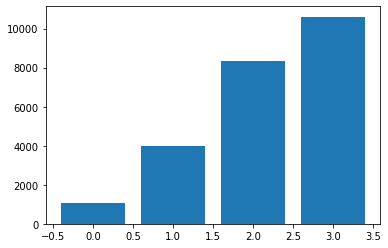





 63%|██████▎   | 95/150 [00:33<00:19,  2.87it/s]

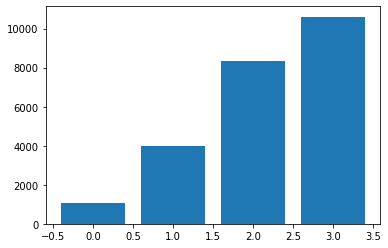





 64%|██████▍   | 96/150 [00:33<00:18,  2.90it/s]

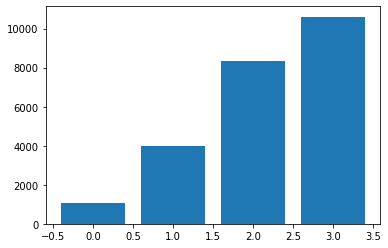





 65%|██████▍   | 97/150 [00:33<00:18,  2.89it/s]

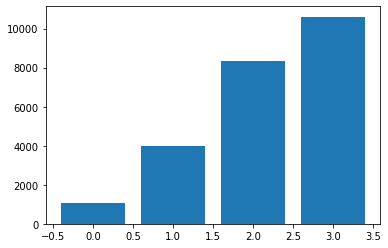





 65%|██████▌   | 98/150 [00:34<00:17,  2.91it/s]

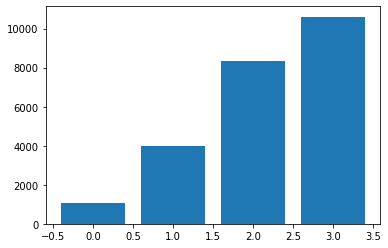





 66%|██████▌   | 99/150 [00:34<00:17,  2.92it/s]

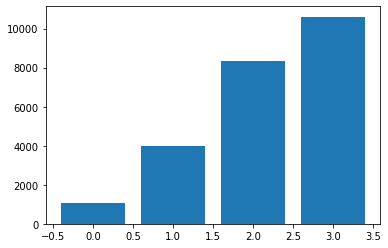





 67%|██████▋   | 100/150 [00:35<00:17,  2.92it/s]

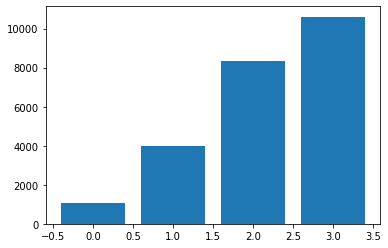





 67%|██████▋   | 101/150 [00:35<00:16,  2.92it/s]

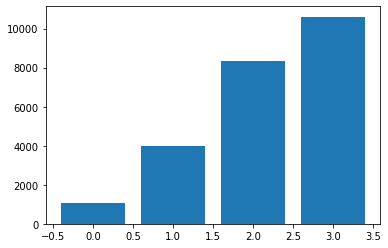





 68%|██████▊   | 102/150 [00:35<00:16,  2.93it/s]

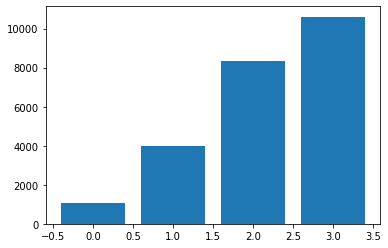





 69%|██████▊   | 103/150 [00:36<00:16,  2.92it/s]

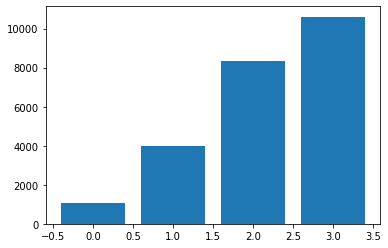





 69%|██████▉   | 104/150 [00:36<00:15,  2.93it/s]

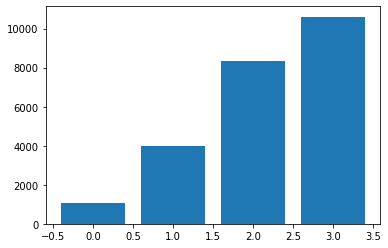





 70%|███████   | 105/150 [00:36<00:15,  2.93it/s]

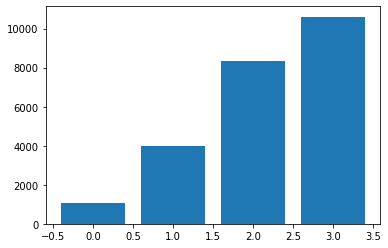





 71%|███████   | 106/150 [00:37<00:14,  2.95it/s]

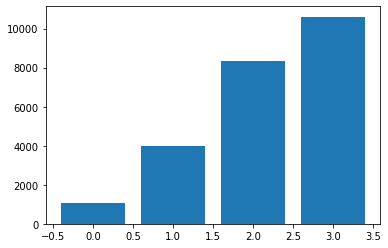





 71%|███████▏  | 107/150 [00:37<00:14,  2.94it/s]

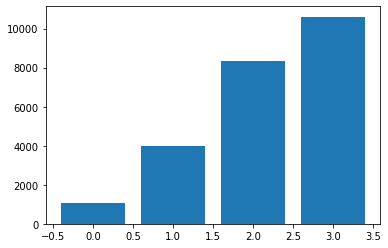





 72%|███████▏  | 108/150 [00:37<00:14,  2.94it/s]

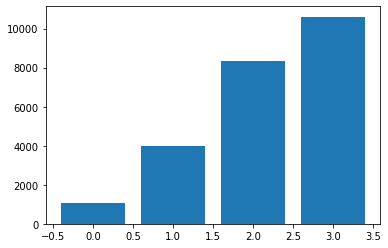





 73%|███████▎  | 109/150 [00:38<00:13,  2.93it/s]

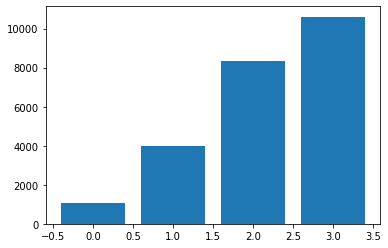





 73%|███████▎  | 110/150 [00:38<00:13,  2.92it/s]

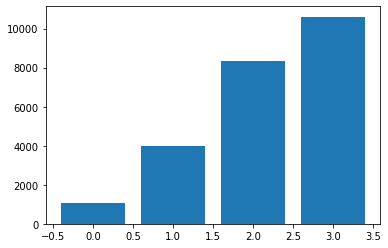





 74%|███████▍  | 111/150 [00:38<00:13,  2.94it/s]

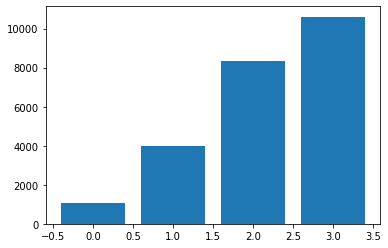





 75%|███████▍  | 112/150 [00:39<00:13,  2.90it/s]

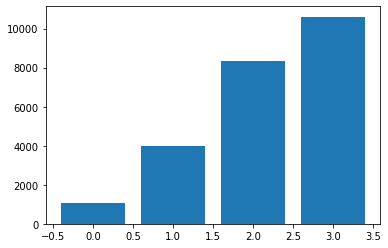





 75%|███████▌  | 113/150 [00:39<00:12,  2.89it/s]

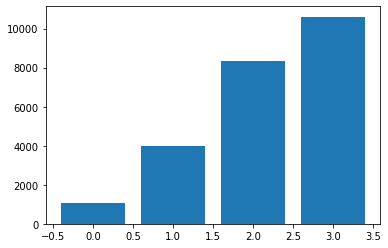





 76%|███████▌  | 114/150 [00:39<00:12,  2.89it/s]

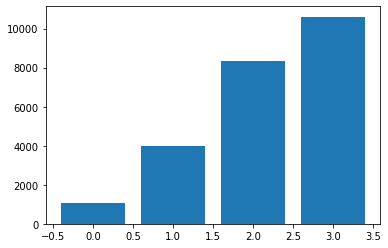





 77%|███████▋  | 115/150 [00:40<00:16,  2.11it/s]

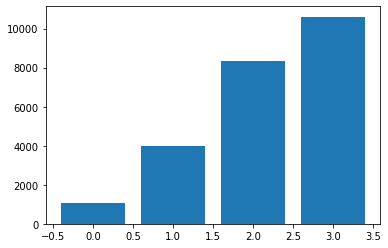





 77%|███████▋  | 116/150 [00:40<00:14,  2.30it/s]

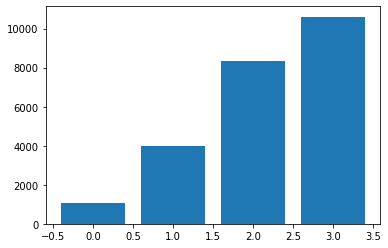





 78%|███████▊  | 117/150 [00:41<00:13,  2.46it/s]

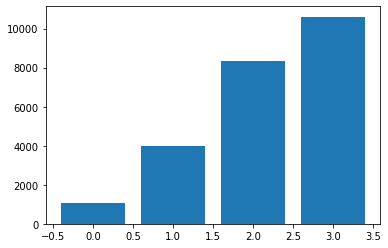





 79%|███████▊  | 118/150 [00:41<00:12,  2.60it/s]

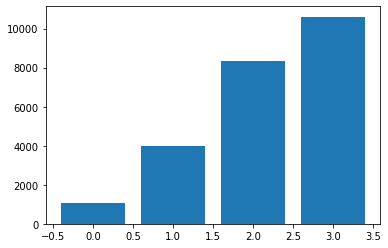





 79%|███████▉  | 119/150 [00:41<00:11,  2.69it/s]

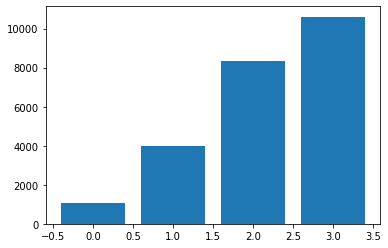





 80%|████████  | 120/150 [00:42<00:10,  2.76it/s]

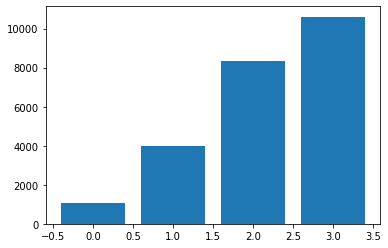





 81%|████████  | 121/150 [00:42<00:10,  2.82it/s]

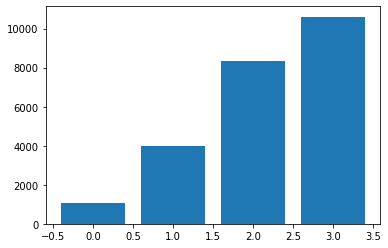





 81%|████████▏ | 122/150 [00:42<00:09,  2.84it/s]

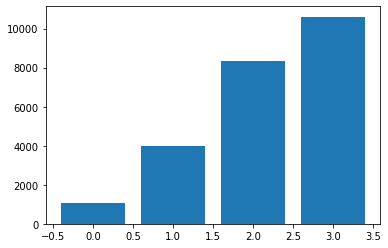





 82%|████████▏ | 123/150 [00:43<00:09,  2.86it/s]

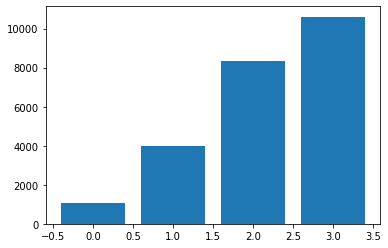





 83%|████████▎ | 124/150 [00:43<00:09,  2.89it/s]

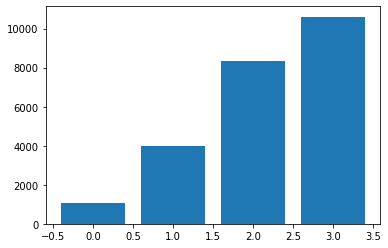





 83%|████████▎ | 125/150 [00:43<00:08,  2.89it/s]

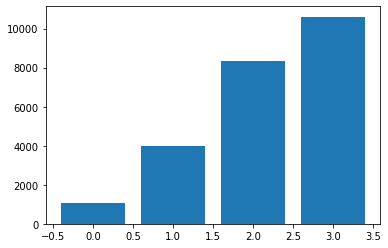





 84%|████████▍ | 126/150 [00:44<00:08,  2.90it/s]

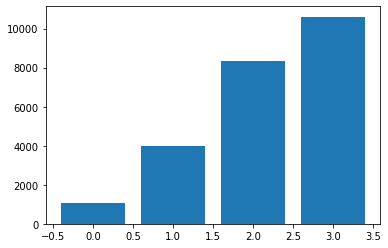





 85%|████████▍ | 127/150 [00:44<00:07,  2.91it/s]

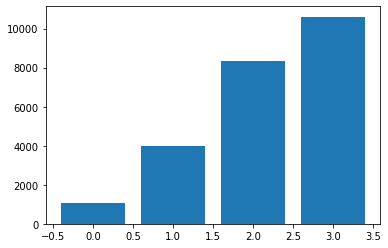





 85%|████████▌ | 128/150 [00:45<00:07,  2.90it/s]

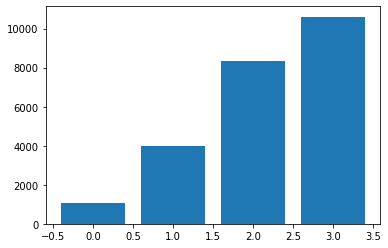





 86%|████████▌ | 129/150 [00:45<00:07,  2.91it/s]

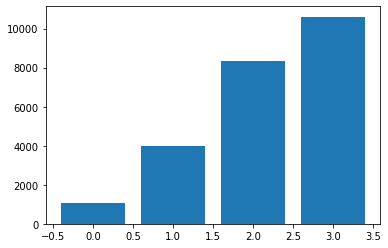





 87%|████████▋ | 130/150 [00:45<00:06,  2.93it/s]

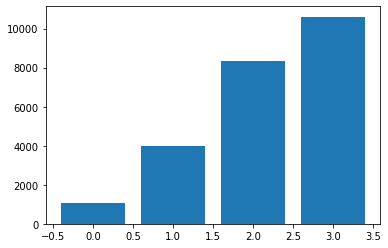





 87%|████████▋ | 131/150 [00:46<00:06,  2.93it/s]

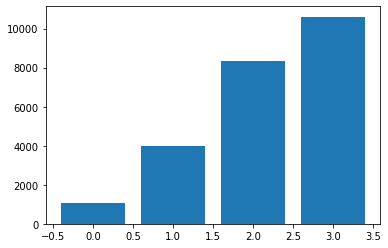





 88%|████████▊ | 132/150 [00:46<00:06,  2.91it/s]

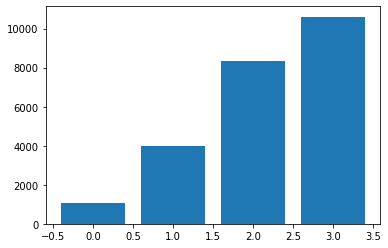





 89%|████████▊ | 133/150 [00:46<00:05,  2.92it/s]

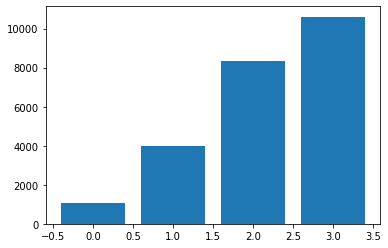





 89%|████████▉ | 134/150 [00:47<00:05,  2.89it/s]

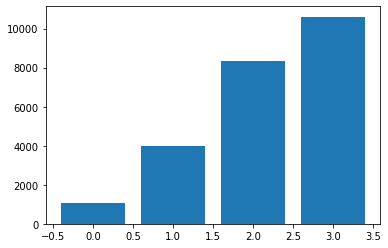





 90%|█████████ | 135/150 [00:47<00:05,  2.90it/s]

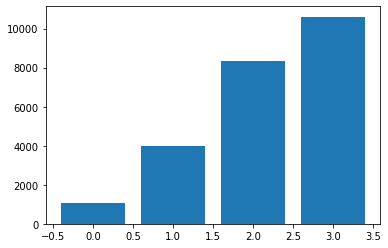





 91%|█████████ | 136/150 [00:47<00:04,  2.91it/s]

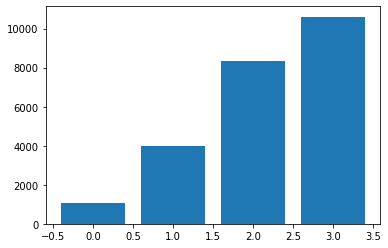





 91%|█████████▏| 137/150 [00:48<00:04,  2.90it/s]

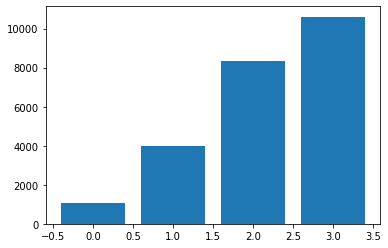





 92%|█████████▏| 138/150 [00:48<00:04,  2.93it/s]

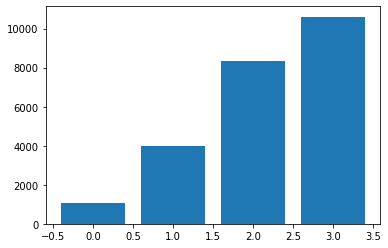





 93%|█████████▎| 139/150 [00:49<00:04,  2.42it/s]

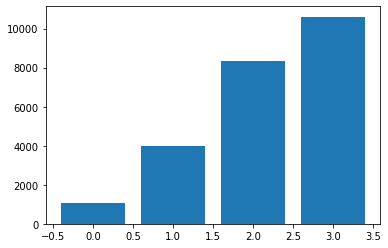





 93%|█████████▎| 140/150 [00:49<00:03,  2.51it/s]

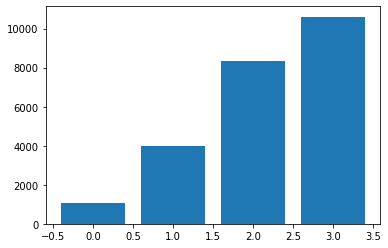





 94%|█████████▍| 141/150 [00:49<00:03,  2.61it/s]

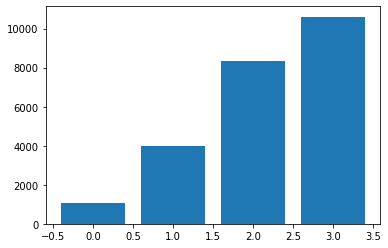





 95%|█████████▍| 142/150 [00:50<00:02,  2.70it/s]

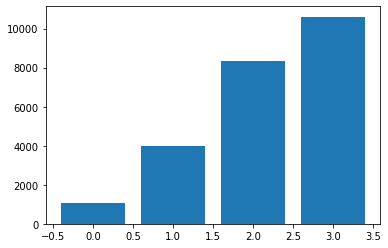





 95%|█████████▌| 143/150 [00:50<00:02,  2.77it/s]

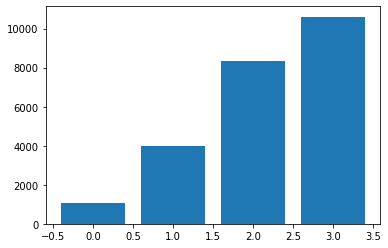





 96%|█████████▌| 144/150 [00:50<00:02,  2.82it/s]

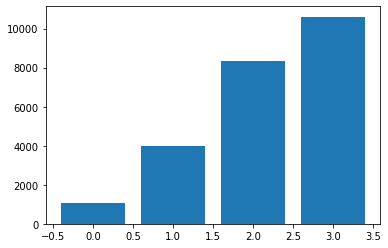





 97%|█████████▋| 145/150 [00:51<00:01,  2.82it/s]

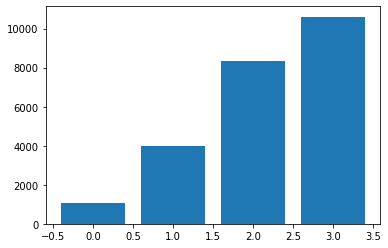





 97%|█████████▋| 146/150 [00:51<00:01,  2.85it/s]

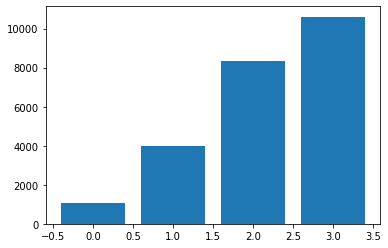





 98%|█████████▊| 147/150 [00:51<00:01,  2.88it/s]

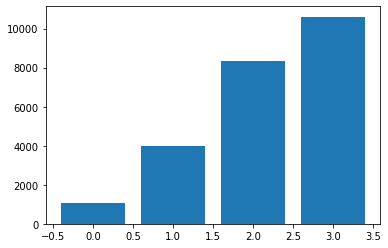





 99%|█████████▊| 148/150 [00:52<00:00,  2.90it/s]

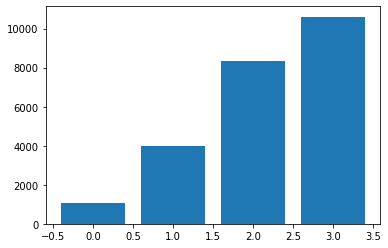





 99%|█████████▉| 149/150 [00:52<00:00,  2.90it/s]

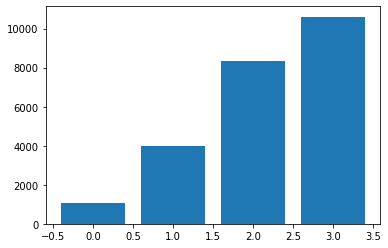





100%|██████████| 150/150 [00:52<00:00,  2.84it/s]


In [0]:
for i in tqdm(range(maxiter)):
    
    for i, c in enumerate(centroids):
        distances[:, i] = get_distances(c, w2v_docs)

    classes = np.argmin(distances, axis=1)
    
    for c in range(k):
        centroids[c] = np.mean(w2v_docs[classes == c], 0)
    plt.bar(list(Counter(classes).keys()), list(Counter(classes).values()))
    plt.show()

In [0]:
feat_cols = [ 'pixel'+str(i) for i in range(w2v_docs.shape[1]) ]
df = pd.DataFrame(w2v_docs,columns=feat_cols)
aux = classes+1
df['y'] = aux
df['true_y'] = train_labels
df['label'] = df['y'].apply(lambda i: str(i))

In [0]:
dfs = []
for i in range(1, 5):
    dfs.append(df.loc[df['y'] == i][:200])

In [0]:
res_df = pd.concat(dfs)

In [0]:
# np.random.seed(42)
# rndperm = np.random.permutation(res_df.shape[0])

In [0]:
data_subset = res_df[feat_cols].values

In [0]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.018s...
[t-SNE] Computed neighbors for 800 samples in 0.507s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.941322
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.332428
[t-SNE] KL divergence after 5000 iterations: 0.804270
t-SNE done! Time elapsed: 70.94353103637695 seconds


In [0]:
res_df['tsne-3d-one'] = tsne_results[:,0]
res_df['tsne-3d-two'] = tsne_results[:,1]
res_df['tsne-3d-three'] = tsne_results[:,2]

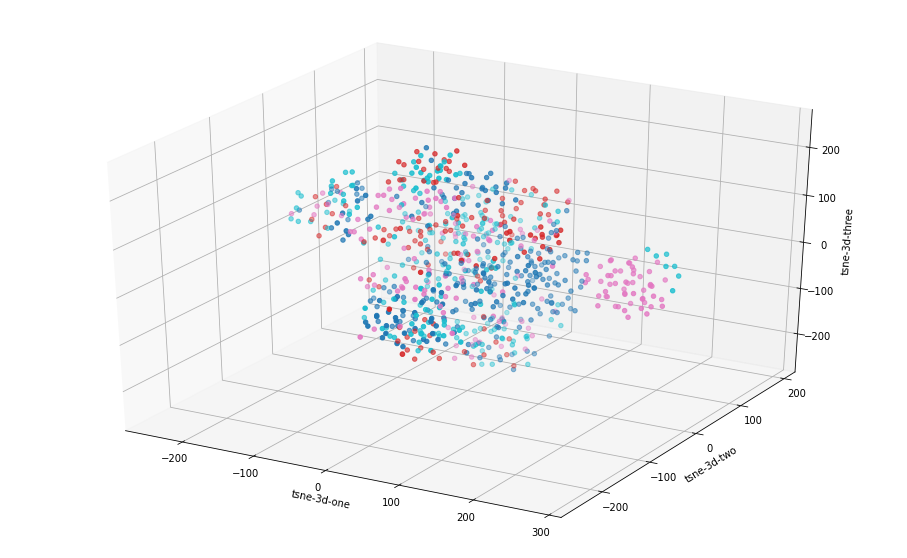

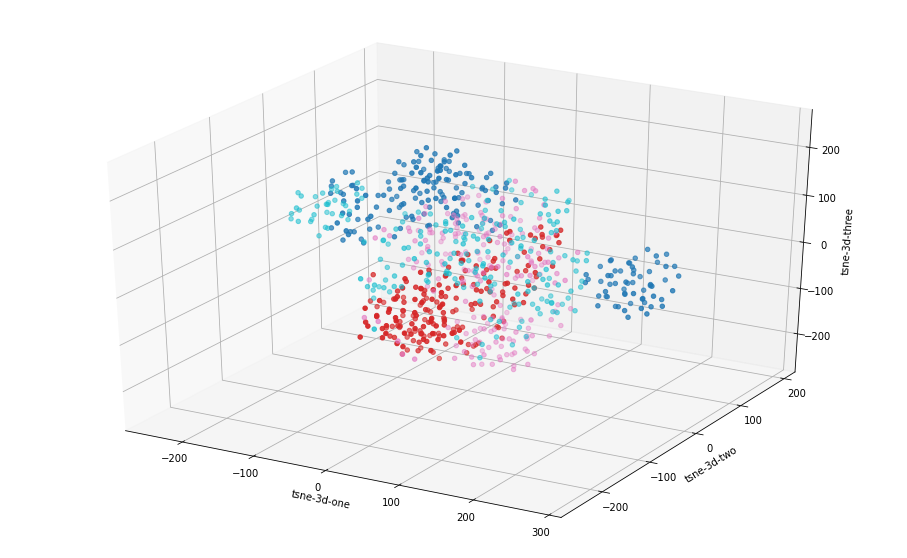

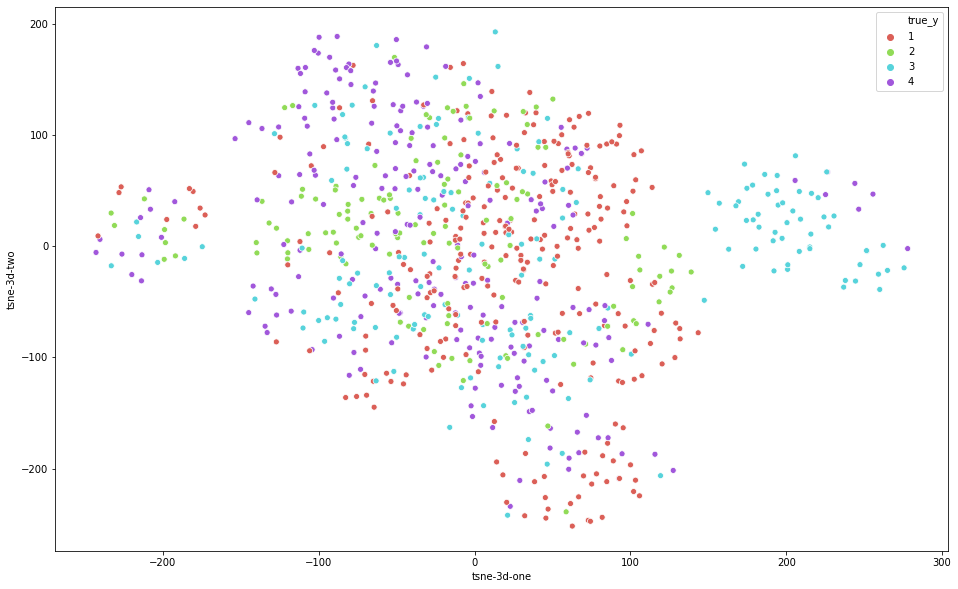

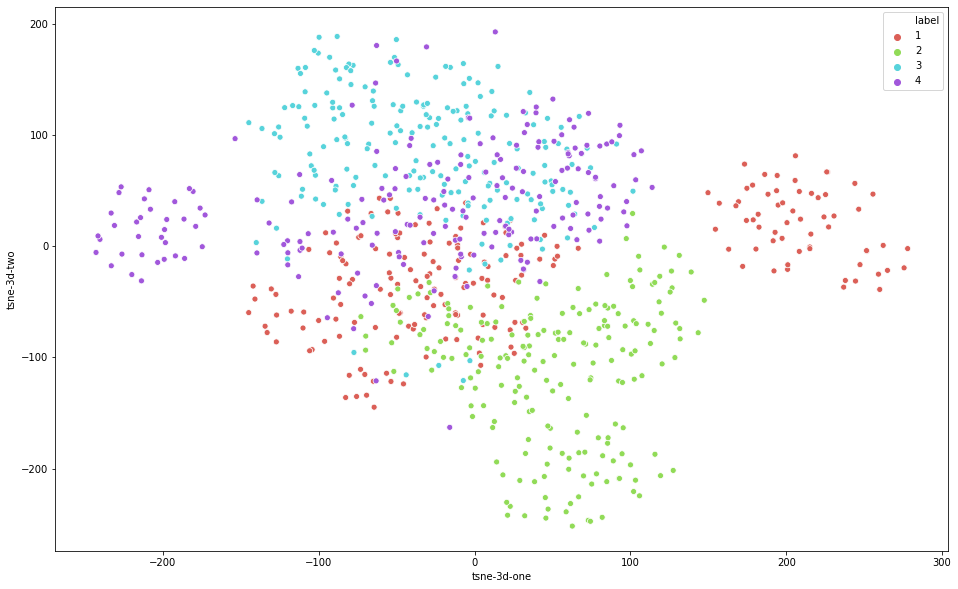

In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=res_df['tsne-3d-one'], 
    ys=res_df['tsne-3d-two'], 
    zs=res_df['tsne-3d-three'], 
    c=res_df['true_y'], 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=res_df['tsne-3d-one'], 
    ys=res_df['tsne-3d-two'], 
    zs=res_df['tsne-3d-three'], 
    c=res_df["y"], 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

plt.figure(figsize=(16,10))
sn.scatterplot(
    x="tsne-3d-one", y="tsne-3d-two",
    hue="true_y",
    palette=sn.color_palette("hls", 4),
    data=res_df,
    legend="full",
    alpha=1,
)
plt.show()

plt.figure(figsize=(16,10))
sn.scatterplot(
    x="tsne-3d-one", y="tsne-3d-two",
    hue="label",
    palette=sn.color_palette("hls", 4),
    data=res_df,
    legend="full",
    alpha=1,
)
plt.show()